# COMP90049 Assignment 3: Job Salary Prediction

# Load Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#read data
train_df = pd.read_csv("raw-data/train.csv")
valid_df = pd.read_csv("raw-data/valid.csv")
test_df = pd.read_csv("raw-data/test.csv")

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13902 entries, 0 to 13901
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   job_id                 13902 non-null  object 
 1   requirements_and_role  13901 non-null  object 
 2   salary_bin             8000 non-null   float64
 3   mean_salary            8000 non-null   float64
 4   gender_code            8000 non-null   float64
dtypes: float64(3), object(2)
memory usage: 543.2+ KB


In [4]:
# only focus on labelled data for our question
train_df = train_df[:8000]
train_df

,job_id,requirements_and_role,salary_bin,mean_salary,gender_code
0,JOB-2019-0015706,role purpose role lead finance team asia offic...,9.0,20833.33333,2.0
1,JOB-2019-0013345,lead cim team source procure implement maintai...,9.0,10000.00000,2.0
2,JOB-2019-0011784,responsibilities lecturer contributions go bey...,4.0,4500.00000,2.0
3,JOB-2019-0013898,preparation welcome kits current savings accou...,6.0,6000.00000,2.0
4,JOB-2019-0000435,full time rto 18 months,3.0,3750.00000,2.0
...,...,...,...,...,...
7995,JOB-2019-0002808,hiring truck driver class 4 driving licence re...,1.0,2400.00000,1.0
7996,JOB-2019-0004419,main roles responsibilities maintain develop r...,5.0,5000.00000,0.0
7997,JOB-2019-0010205,ying right place work hard fun office wall mea...,3.0,3600.00000,0.0
7998,JOB-2019-0001561,role microstrategy consultants empower custome...,7.0,6500.00000,0.0


In [5]:
train_df.describe()

,salary_bin,mean_salary,gender_code
count,8000.000000,8000.000000,8000.000000
mean,4.514750,5374.340922,1.381750
std,2.897384,3420.668603,0.835526
min,0.000000,500.000000,0.000000
25%,2.000000,3000.000000,1.000000
50%,4.000000,4500.000000,2.000000
75%,7.000000,6875.000000,2.000000
max,9.000000,65000.000000,2.000000


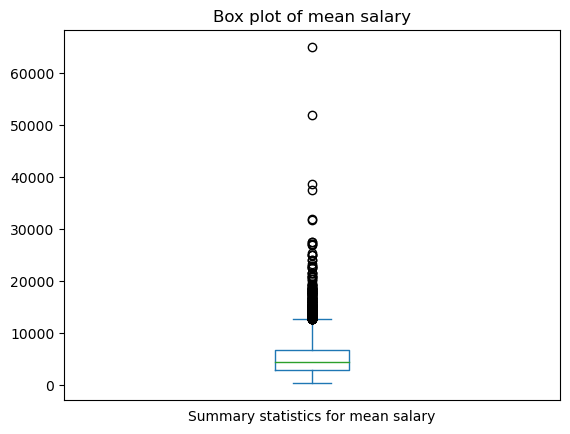

In [6]:
train_df['mean_salary'].plot.box(title="Box plot of mean salary", xticks=[])
plt.xlabel('Summary statistics for mean salary');

plt.show(block=True);

In [7]:
salary_bin_boundary = list(train_df.groupby(['salary_bin'])['mean_salary'].max().reset_index()['mean_salary'])
salary_bin_boundary

[2200.0,
 2650.0,
 3150.0,
 3750.0,
 4500.0,
 5250.0,
 6250.0,
 7250.0,
 9200.0,
 65000.0]

Salary bins boundary: [< 2,200, 2,200-2,650, 2,650-3,150, 3,150-3,750, 3,750-4,500, 4,500-5,250, 5,250-6,250, 6,250-7,250, 7,250-9,200, 9,200-65,000, >65,000]

In [8]:
# get salary_bin
train_salary_bin = train_df["salary_bin"].to_numpy().astype(int)
valid_salary_bin = valid_df["salary_bin"].to_numpy().astype(int)

# Load Word embeddings and TF-IDF

In [5]:
train_embeddings = np.load("embeddings-data/train-embeddings.npy")
train_tfidf = np.load("tfidf-data/train-tfidf.npy")

valid_embeddings = np.load("embeddings-data/valid-embeddings.npy")
valid_tfidf = np.load("tfidf-data/valid-tfidf.npy")

test_embeddings = np.load("embeddings-data/test-embeddings.npy")
test_tfidf = np.load("tfidf-data/test-tfidf.npy")


In [10]:
train_label_embeddings = train_embeddings[:8000, :]
train_label_tfidf = train_tfidf[:8000, :]
train_cls_labels = train_salary_bin[:8000]

# EDA

In [11]:
train_df['salary_bin']

0       9.0
1       9.0
2       4.0
3       6.0
4       3.0
       ... 
7995    1.0
7996    5.0
7997    3.0
7998    7.0
7999    9.0
Name: salary_bin, Length: 8000, dtype: float64

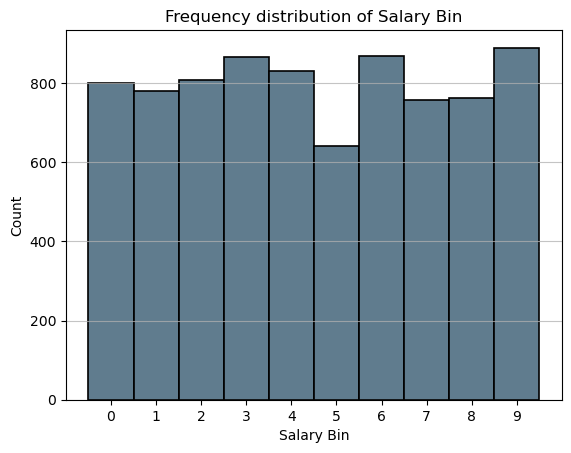

In [12]:


salary_bin_bar = train_df['salary_bin']


plt.hist(salary_bin_bar, bins=np.arange(11) - 0.5, color='#607c8e',edgecolor='black', linewidth=1.2)
plt.xticks(np.arange(0, 10, 1))
plt.title('Frequency distribution of Salary Bin')
plt.xlabel('Salary Bin')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)


## Analysis the word token

In [30]:
word_df = pd.read_csv("../tfidf-data/tfidf_words.csv", header=None)
word_df

,0,1
0,ability,0
1,able,1
2,accordance,2
3,according,3
4,account,4
...,...,...
495,working,495
496,works,496
497,world,497
498,year,498


In [31]:
def get_word_per_row(word_df, train_tfidf):
    def sort_df(df):
        return pd.DataFrame(
            data=df.columns.values[np.argsort(-df.values, axis=1)],
            columns=[i for i in range(df.shape[1])]
        )
    
    word_train_tfidf = pd.DataFrame(train_tfidf, columns = list(word_df[0]))
    word_train_tfidf= word_train_tfidf.replace(0, np.nan)
    sort_word_train_tfidf = pd.DataFrame(np.sort(-word_train_tfidf.values, axis=1))
    sort_word_train_tfidf[sort_word_train_tfidf <0] = True
    pre_word_per_row = sort_df(word_train_tfidf)
    word_per_row = pre_word_per_row[sort_word_train_tfidf == True]
    #print(word_per_row.iloc[:, :10].values.tolist())
    return [[y for y in x if pd.notna(y)] for x in word_per_row.iloc[:, :5].values.tolist()]

In [32]:
word_per_row = get_word_per_row(word_df, train_label_tfidf)
word_per_row

[['financial', 'tax', 'office', 'accounting', 'asia'],
 ['end', 'systems', 'cross', 'users', 'user'],
 ['industry', 'design', 'experience', 'learning', 'strong'],
 ['customers', 'accounts', 'coordination', 'handling', 'data'],
 ['time'],
 ['drawings', 'specifications', 'customers', 'tender', 'controls'],
 ['perform', 'report', 'vendor', 'status', 'establish'],
 ['digital', 'creative', 'design', 'ideas', 'excellent'],
 ['market', 'good', 'clients', 'services', 'new'],
 ['payment', 'time', 'customer', 'company', 'claims'],
 ['bank', 'support', 'trade', 'solutions', 'teams'],
 ['quality', 'members', 'collaborate', 'effectively', 'team'],
 ['media', 'sales', 'solutions', 'target', 'annual'],
 ['safety', 'construction', 'projects', 'infrastructure', 'cost'],
 ['development', 'travel', 'research', 'market', 'software'],
 ['administrative'],
 ['progress', 'prepare', 'tender', 'claims', 'submission'],
 ['marketing', 'new', 'experience', 'good', 'campaigns'],
 ['general', 'business', 'regional'

In [33]:
train_df['token'] = word_per_row

In [34]:
word_cat = train_df.groupby('salary_bin').agg({ 'token': 'sum'})
word_cat

,token
salary_bin,
0.0,"[payment, time, customer, company, claims, dri..."
1.0,"[perform, report, vendor, status, establish, a..."
2.0,"[quality, members, collaborate, effectively, t..."
3.0,"[time, drawings, specifications, customers, te..."
4.0,"[industry, design, experience, learning, stron..."
5.0,"[marketing, new, experience, good, campaigns, ..."
6.0,"[customers, accounts, coordination, handling, ..."
7.0,"[safety, construction, projects, infrastructur..."
8.0,"[media, sales, solutions, target, annual, mark..."


In [35]:
from collections import Counter
x = Counter(word_cat['token'][0])
x.most_common(10)

[('customers', 59),
 ('duties', 59),
 ('customer', 57),
 ('assist', 56),
 ('sales', 52),
 ('stock', 49),
 ('perform', 44),
 ('orders', 44),
 ('food', 41),
 ('handle', 41)]

In [36]:
from collections import Counter
x = Counter(word_cat['token'][1])
x.most_common(10)

[('sales', 63),
 ('customers', 48),
 ('customer', 43),
 ('clients', 42),
 ('day', 41),
 ('assist', 39),
 ('service', 37),
 ('project', 37),
 ('duties', 35),
 ('prepare', 35)]

In [20]:
from collections import Counter
x = Counter(word_cat['token'][2])
x.most_common(10)

[('sales', 75),
 ('project', 52),
 ('customers', 48),
 ('prepare', 44),
 ('clients', 43),
 ('customer', 41),
 ('assist', 39),
 ('design', 37),
 ('site', 33),
 ('marketing', 30)]

In [21]:
from collections import Counter
x = Counter(word_cat['token'][3])
x.most_common(10)

[('project', 71),
 ('sales', 65),
 ('design', 52),
 ('customers', 39),
 ('site', 38),
 ('research', 37),
 ('customer', 36),
 ('drawings', 35),
 ('clients', 35),
 ('day', 30)]

In [22]:
from collections import Counter
x = Counter(word_cat['token'][4])
x.most_common(10)

[('design', 63),
 ('project', 60),
 ('sales', 59),
 ('experience', 39),
 ('clients', 38),
 ('customer', 37),
 ('business', 36),
 ('research', 35),
 ('data', 34),
 ('software', 32)]

In [23]:
from collections import Counter
x = Counter(word_cat['token'][5])
x.most_common(10)

[('design', 51),
 ('project', 41),
 ('data', 35),
 ('business', 32),
 ('sales', 32),
 ('research', 30),
 ('software', 29),
 ('experience', 27),
 ('support', 27),
 ('client', 23)]

In [24]:
from collections import Counter
x = Counter(word_cat['token'][6])
x.most_common(10)

[('project', 68),
 ('design', 62),
 ('business', 56),
 ('sales', 46),
 ('data', 45),
 ('support', 41),
 ('software', 40),
 ('development', 39),
 ('experience', 37),
 ('research', 37)]

In [25]:
from collections import Counter
x = Counter(word_cat['token'][7])
x.most_common(10)

[('project', 64),
 ('business', 60),
 ('experience', 56),
 ('design', 51),
 ('software', 41),
 ('sales', 40),
 ('technical', 38),
 ('data', 37),
 ('security', 37),
 ('application', 33)]

In [26]:
from collections import Counter
x = Counter(word_cat['token'][8])
x.most_common(10)

[('business', 84),
 ('project', 72),
 ('sales', 49),
 ('design', 41),
 ('development', 39),
 ('management', 39),
 ('product', 38),
 ('data', 37),
 ('client', 36),
 ('technical', 35)]

In [27]:
from collections import Counter
x = Counter(word_cat['token'][9])
x.most_common(10)

[('business', 126),
 ('project', 73),
 ('team', 56),
 ('product', 55),
 ('sales', 52),
 ('global', 49),
 ('marketing', 49),
 ('technical', 44),
 ('data', 42),
 ('regional', 40)]

## Distribition of job by gender

In [37]:
gender_counts = train_df['gender_code'].value_counts()
gender_counts

2.0    4902
0.0    1848
1.0    1250
Name: gender_code, dtype: int64

In [38]:
agg_plot = train_df.groupby(['salary_bin', 'gender_code'])['job_id'].count().unstack()
agg_plot

gender_code,0.0,1.0,2.0
salary_bin,,,
0.0,225,297,279
1.0,203,231,345
2.0,201,162,445
3.0,194,126,545
4.0,177,101,553
5.0,128,49,464
6.0,173,94,600
7.0,141,64,551
8.0,151,57,555


In [40]:
# for excel
agg_plot[0]/agg_plot[0].sum()

salary_bin
0.0    0.121753
1.0    0.109848
2.0    0.108766
3.0    0.104978
4.0    0.095779
5.0    0.069264
6.0    0.093615
7.0    0.076299
8.0    0.081710
9.0    0.137987
Name: 0.0, dtype: float64

In [41]:
# for excel
agg_plot[1]/agg_plot[1].sum()

salary_bin
0.0    0.2376
1.0    0.1848
2.0    0.1296
3.0    0.1008
4.0    0.0808
5.0    0.0392
6.0    0.0752
7.0    0.0512
8.0    0.0456
9.0    0.0552
Name: 1.0, dtype: float64

In [42]:
# for excel
agg_plot[2]/agg_plot[2].sum()

salary_bin
0.0    0.056916
1.0    0.070379
2.0    0.090779
3.0    0.111179
4.0    0.112811
5.0    0.094655
6.0    0.122399
7.0    0.112403
8.0    0.113219
9.0    0.115259
Name: 2.0, dtype: float64

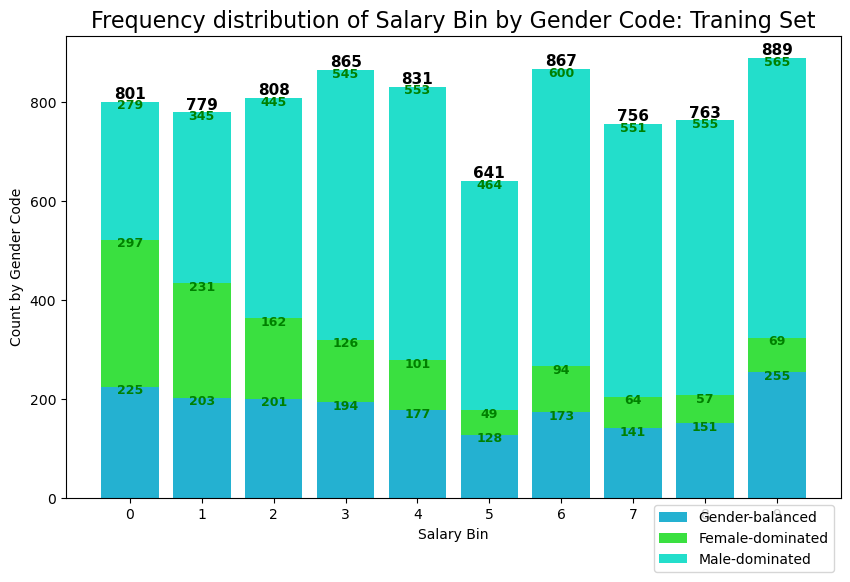

In [46]:
fig, ax = plt.subplots(figsize=(10, 6))
label_dic={0:'Gender-balanced', 1:'Female-dominated', 2:'Male-dominated'}
colors = ['#24b1d1', '#3ae040', '#23decb']

# Initialize the bottom at zero for the first set of bars.
bottom = np.zeros(len(agg_plot))

# Plot each layer of the bar, adding each bar to the "bottom" so
# the next bar starts higher.
for i, col in enumerate(agg_plot.columns):
    ax.bar(agg_plot.index, agg_plot[col], bottom=bottom, label=label_dic[i], color=colors[i])
    bottom += np.array(agg_plot[col])
    
    
# Sum up the rows of our data to get the total value of each bar.
totals = agg_plot.sum(axis=1)

# Set an offset that is used to bump the label up a bit above the bar.
y_offset = 6

# Add labels to each bar.
for i, total in enumerate(totals):
    ax.text(totals.index[i], total + y_offset, round(total), ha='center',
          weight='bold',size=11)

    
# Let's put the annotations inside the bars themselves by using a
# negative offset.
y_offset = -15
# For each patch (basically each rectangle within the bar), add a label.
for bar in ax.patches:
    ax.text(
      # Put the text in the middle of each bar. get_x returns the start
      # so we add half the width to get to the middle.
      bar.get_x() + bar.get_width() / 2,
      # Vertically, add the height of the bar to the start of the bar,
      # along with the offset.
      bar.get_height() + bar.get_y() + y_offset,
      # This is actual value we'll show.
      round(bar.get_height()),
      # Center the labels and style them a bit.
      ha='center',
      color='g',
      weight='bold',
      size=9
  )    
    
plt.xticks(np.arange(0, 10, 1))
ax.set_title('Frequency distribution of Salary Bin by Gender Code: Traning Set', size = 16)
plt.xlabel('Salary Bin')
plt.ylabel('Count by Gender Code')
ax.legend(bbox_to_anchor=(1, 0))

# Classification Task

# DT

In [48]:
# Import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
# Import train_test_split

# Instantiate dt, set 'criterion' to 'gini'
dt = DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=1)

dt.fit(train_label_embeddings, train_cls_labels)
valid_pred = dt.predict(valid_embeddings)

print("embeddings Logistic Regressions")
print(classification_report(valid_salary_bin, valid_pred))


embeddings Logistic Regressions
              precision    recall  f1-score   support

           0       0.33      0.31      0.32       180
           1       0.15      0.17      0.16       142
           2       0.16      0.14      0.15       181
           3       0.14      0.16      0.15       190
           4       0.16      0.14      0.15       201
           5       0.13      0.13      0.13       150
           6       0.09      0.11      0.10       178
           7       0.18      0.13      0.15       171
           8       0.13      0.13      0.13       171
           9       0.26      0.27      0.26       173

    accuracy                           0.17      1737
   macro avg       0.17      0.17      0.17      1737
weighted avg       0.17      0.17      0.17      1737



In [49]:
text_representation = tree.export_text(dt)

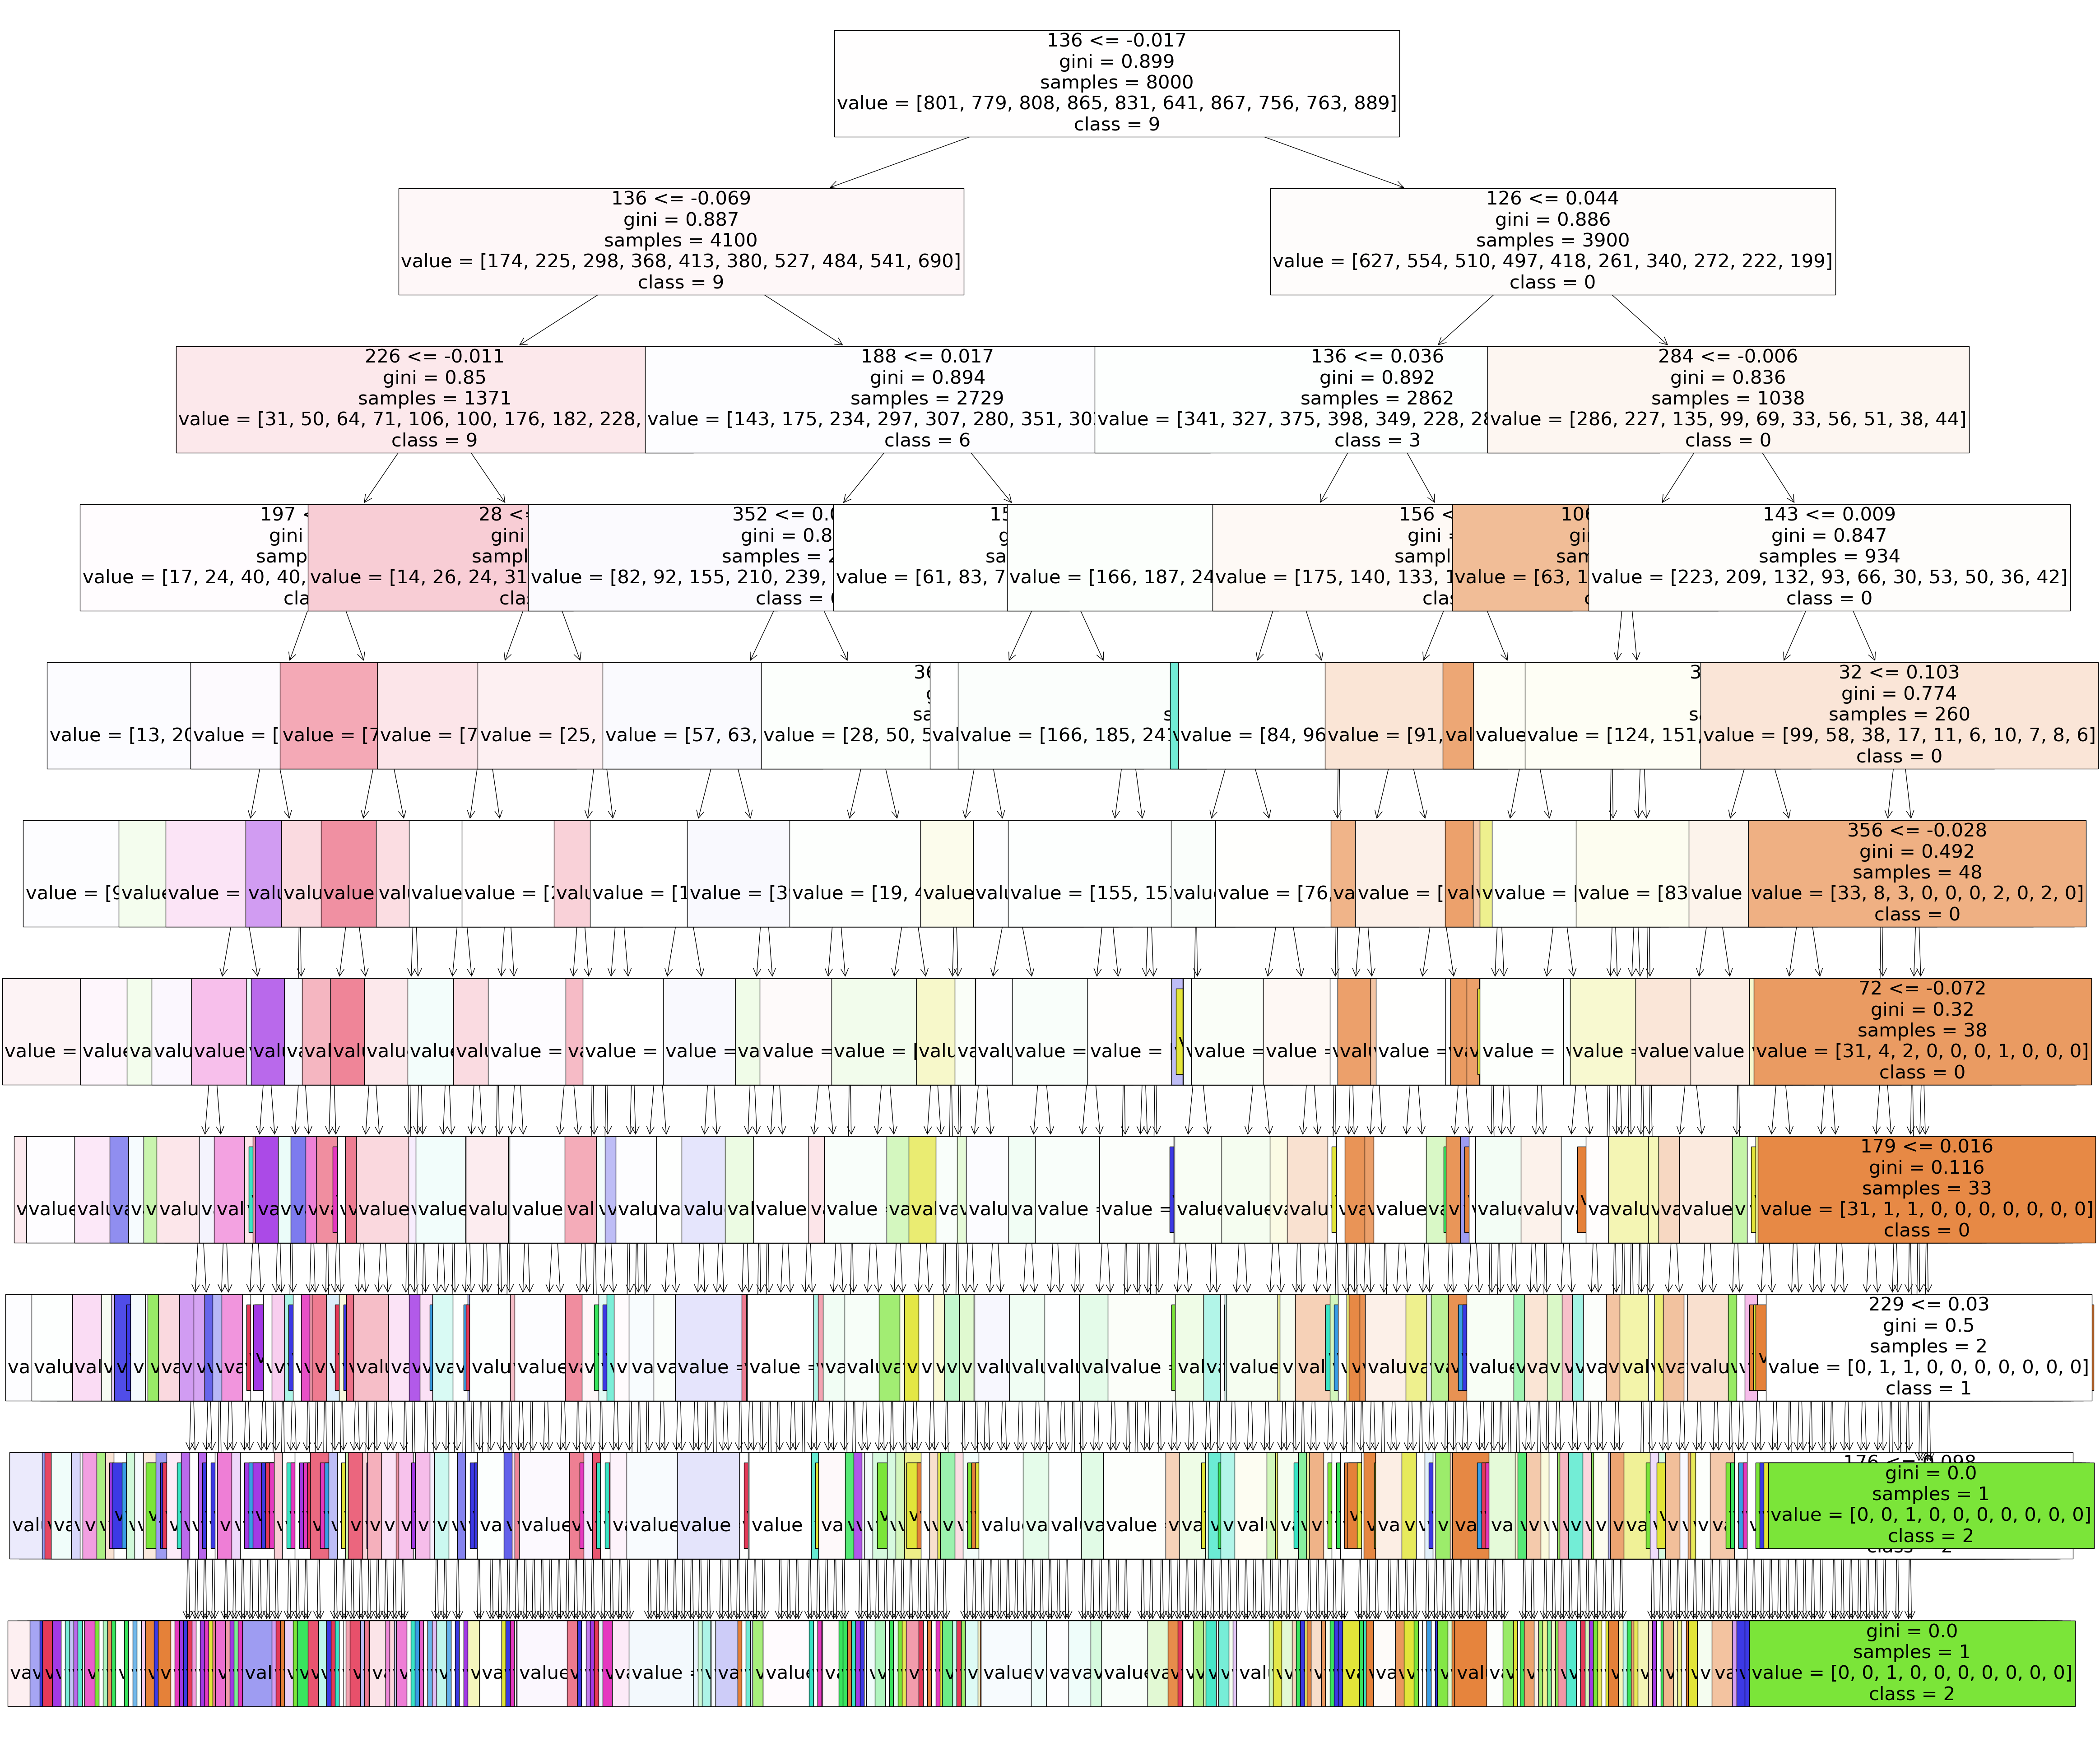

In [51]:
"""fig = plt.figure(figsize=(50,50))
_ = tree.plot_tree(dt, 
                   feature_names=[str(x) for x in list(range(384))],  
                   class_names=[str(x) for x in list(range(10))],
                   filled=True, fontsize=30)
"""

# 1. Logistic Regression

## Parameter Fine Tunning

In [52]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
# fine tunning

params = {"C":np.linspace(0.1, 1, 10, 50)}
kf = KFold(n_splits=5, shuffle=True, random_state=1)
logreg = LogisticRegression(max_iter=800)


logreg_cv = GridSearchCV(logreg,params, cv=3)
logreg_cv.fit(valid_embeddings, valid_salary_bin)
print("embedding", logreg_cv.best_params_, logreg_cv.best_score_)

logreg_cv = GridSearchCV(logreg,params, cv=3)
logreg_cv.fit(valid_tfidf, valid_salary_bin)
print("tfidf", logreg_cv.best_params_, logreg_cv.best_score_)



embedding {'C': 0.7000000000000001} 0.23200921128382268
tfidf {'C': 0.2} 0.21531375935521013


## Classification for embedding feature

In [53]:

## classification for embedding features

logreg = LogisticRegression(max_iter=800, C=0.7 )
logreg.fit(train_label_embeddings, train_cls_labels)
valid_pred = logreg.predict(valid_embeddings)

print("Logistic Regressions with embeddings")
print(classification_report(valid_salary_bin, valid_pred, digits=3))



Logistic Regressions with embeddings
              precision    recall  f1-score   support

           0      0.425     0.594     0.495       180
           1      0.191     0.232     0.210       142
           2      0.190     0.160     0.174       181
           3      0.154     0.142     0.148       190
           4      0.199     0.174     0.186       201
           5      0.083     0.013     0.023       150
           6      0.217     0.230     0.223       178
           7      0.211     0.164     0.184       171
           8      0.232     0.135     0.170       171
           9      0.270     0.566     0.366       173

    accuracy                          0.244      1737
   macro avg      0.217     0.241     0.218      1737
weighted avg      0.219     0.244     0.220      1737



### Fairness

In [56]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import  confusion_matrix
# some random numbers
y_true = valid_salary_bin
y_pred = valid_pred
sensitive_features =valid_df['gender_code'].to_numpy()

# pandified confusion matrix with clarifying column annotations 
def confusion_matrix_pd(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred, normalize='all')
    return pd.DataFrame(matrix).rename(
               index={0: "true=0", 1: "true=1", 2: "true=2",3: "true=3", 4: "true=4", 5: "true=5",6: "true=6", 7: "true=7", 8: "true=8", 9: "true=9"},
               columns={0: "pred=0", 1: "pred=1", 2: "pred=2",3: "pred=3", 4: "pred=4", 5: "pred=5",6: "pred=6", 7: "pred=7", 8: "pred=8", 9: "pred=9"}).stack()

# construct metric frame
mf = MetricFrame(metric=confusion_matrix_pd, 
                  y_true=y_true, y_pred=y_pred, 
                  sensitive_features=sensitive_features)

# mf.by_group needs to be transformed to work properly
mega_group_df = pd.DataFrame(mf.by_group.to_dict()).T.rename_axis(index='sensitive_feature_0')
mega_group_df_final = (mega_group_df['true=0'] + mega_group_df['true=1']+ mega_group_df['true=2']+ mega_group_df['true=3']
+ mega_group_df['true=4']+ mega_group_df['true=5']+ mega_group_df['true=6']+ mega_group_df['true=7']
+ mega_group_df['true=8']+ mega_group_df['true=9'])
mega_group_df_final

/Users/lornay/opt/anaconda3/envs/AI/lib/python3.8/site-packages/fairlearn/metrics/_metric_frame.py:82: FutureWarning: The positional argument 'metric' has been replaced by a keyword argument 'metrics'. From version 0.10.0 passing it as a positional argument or as a keyword argument 'metric' will result in an error
  warnings.warn(


,pred=0,pred=1,pred=2,pred=3,pred=4,pred=5,pred=6,pred=7,pred=8,pred=9
sensitive_feature_0,,,,,,,,,,
0,0.149333,0.114667,0.128000,0.101333,0.085333,0.008000,0.058667,0.029333,0.034667,0.290667
1,0.363322,0.231834,0.079585,0.096886,0.044983,0.003460,0.034602,0.017301,0.003460,0.124567
2,0.084809,0.058714,0.076421,0.101584,0.122088,0.018639,0.146319,0.109040,0.079217,0.203169


In [57]:
mega_group_df_final = mega_group_df_final.round(2)
mega_group_df_final = mega_group_df_final.T
mega_group_df_final

sensitive_feature_0,0,1,2
pred=0,0.15,0.36,0.08
pred=1,0.11,0.23,0.06
pred=2,0.13,0.08,0.08
pred=3,0.10,0.10,0.10
pred=4,0.09,0.04,0.12
pred=5,0.01,0.00,0.02
pred=6,0.06,0.03,0.15
pred=7,0.03,0.02,0.11
pred=8,0.03,0.00,0.08
pred=9,0.29,0.12,0.20


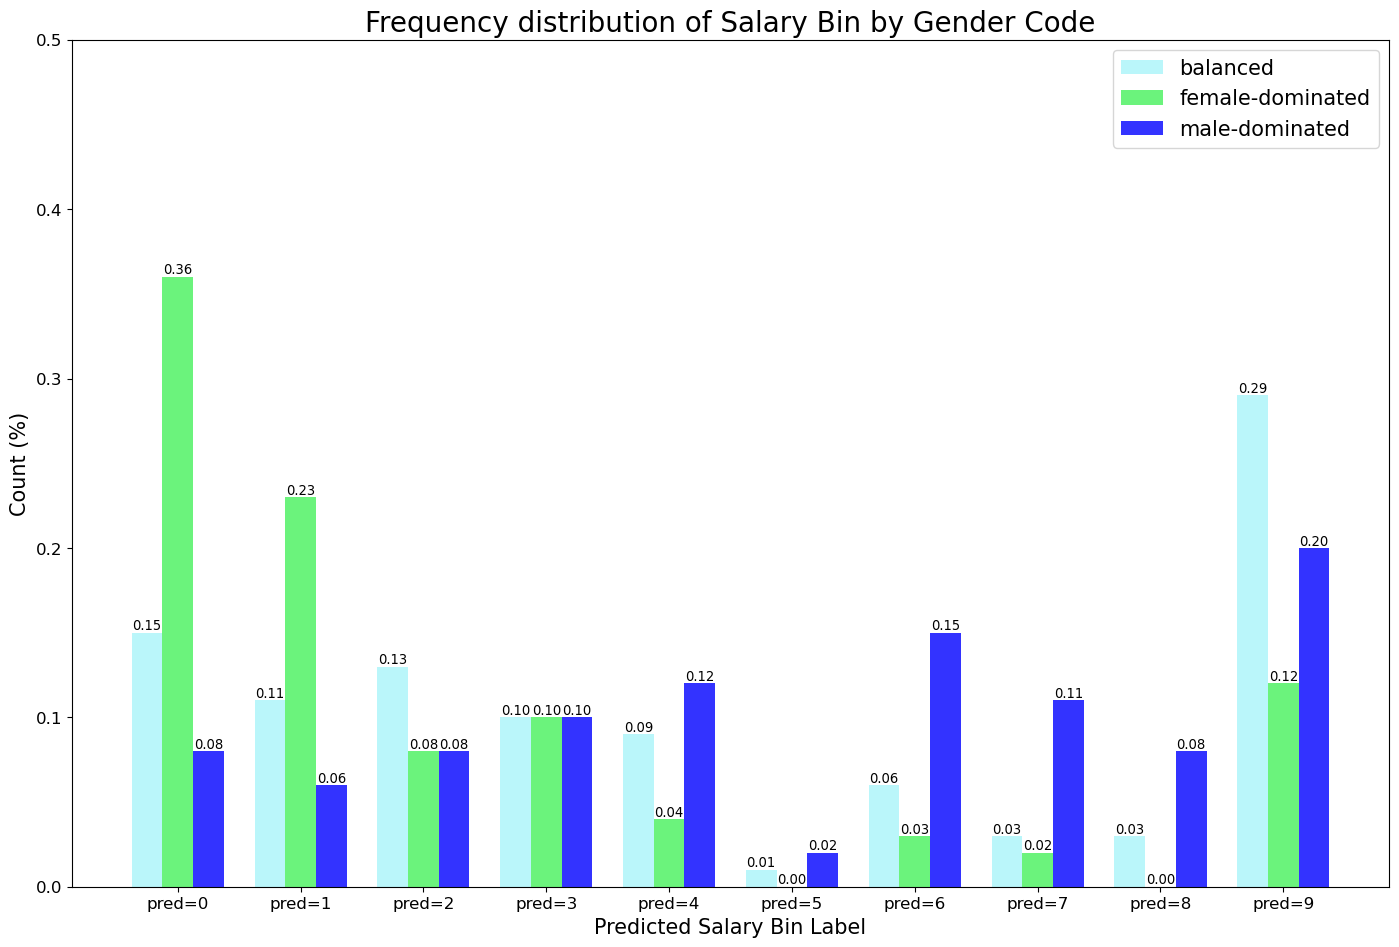

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(17,11))
x_labels = list(range(10))

bar0_height = list(mega_group_df_final[0])
bar1_height = list(mega_group_df_final[1])
bar2_height = list(mega_group_df_final[2])

bar1 = plt.bar(x = [i - 0.25 for i in range(10)], height = bar0_height, width = 0.25, alpha = 0.8, color = '#A9F4F9',label = 'balanced')  
bar2 = plt.bar(x = [i for i in range(10)], height = bar1_height, width = 0.25, alpha = 0.8, color = '#46F15B',label = 'female-dominated')  
bar3 = plt.bar(x = [i + 0.25 for i in range(10)], height = bar2_height, width = 0.25, alpha = 0.8, color = 'b',label = 'male-dominated')  

plt.bar_label(bar1, fmt='%.2f', size=9.5)
plt.bar_label(bar2, fmt='%.2f', size=9.5)
plt.bar_label(bar3, fmt='%.2f', size=9.5)

plt.ylabel('Count (%)', size= 15)
plt.xlabel('Predicted Salary Bin Label', size= 15)
plt.title('Frequency distribution of Salary Bin by Gender Code', size =20)
plt.ylim([0.0, 0.5])
plt.xticks(list(range(10)), list(mega_group_df_final.index), size= 12)
plt.yticks(fontsize=12)
plt.legend(prop={'size': 15}) 
plt.show()

## Classification for tfidf features

In [59]:
## classification for tfidf features

logreg = LogisticRegression(max_iter=800, C=0.2 )
logreg.fit(train_label_tfidf, train_cls_labels)
valid_pred = logreg.predict(valid_tfidf)

print("Logistic Regressions with tfidf")
print(classification_report(valid_salary_bin, valid_pred, digits=3))

Logistic Regressions with tfidf
              precision    recall  f1-score   support

           0      0.400     0.622     0.487       180
           1      0.182     0.176     0.179       142
           2      0.192     0.166     0.178       181
           3      0.172     0.174     0.173       190
           4      0.144     0.109     0.124       201
           5      0.091     0.007     0.012       150
           6      0.144     0.169     0.155       178
           7      0.155     0.129     0.141       171
           8      0.146     0.076     0.100       171
           9      0.258     0.549     0.351       173

    accuracy                          0.220      1737
   macro avg      0.188     0.218     0.190      1737
weighted avg      0.190     0.220     0.193      1737



## Fairness

In [60]:

# some random numbers
y_true = valid_salary_bin
y_pred = valid_pred
sensitive_features =valid_df['gender_code'].to_numpy()

# pandified confusion matrix with clarifying column annotations 
def confusion_matrix_pd(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred, normalize='all')
    return pd.DataFrame(matrix).rename(
               index={0: "true=0", 1: "true=1", 2: "true=2",3: "true=3", 4: "true=4", 5: "true=5",6: "true=6", 7: "true=7", 8: "true=8", 9: "true=9"},
               columns={0: "pred=0", 1: "pred=1", 2: "pred=2",3: "pred=3", 4: "pred=4", 5: "pred=5",6: "pred=6", 7: "pred=7", 8: "pred=8", 9: "pred=9"}).stack()

# construct metric frame
mf = MetricFrame(metric=confusion_matrix_pd, 
                  y_true=y_true, y_pred=y_pred, 
                  sensitive_features=sensitive_features)

# mf.by_group needs to be transformed to work properly
mega_group_df = pd.DataFrame(mf.by_group.to_dict()).T.rename_axis(index='sensitive_feature_0')
mega_group_df_final = (mega_group_df['true=0'] + mega_group_df['true=1']+ mega_group_df['true=2']+ mega_group_df['true=3']
+ mega_group_df['true=4']+ mega_group_df['true=5']+ mega_group_df['true=6']+ mega_group_df['true=7']
+ mega_group_df['true=8']+ mega_group_df['true=9'])
mega_group_df_final

/Users/lornay/opt/anaconda3/envs/AI/lib/python3.8/site-packages/fairlearn/metrics/_metric_frame.py:82: FutureWarning: The positional argument 'metric' has been replaced by a keyword argument 'metrics'. From version 0.10.0 passing it as a positional argument or as a keyword argument 'metric' will result in an error
  warnings.warn(


,pred=0,pred=1,pred=2,pred=3,pred=4,pred=5,pred=6,pred=7,pred=8,pred=9
sensitive_feature_0,,,,,,,,,,
0,0.192000,0.077333,0.112000,0.090667,0.088000,0.008000,0.085333,0.024000,0.024000,0.298667
1,0.377163,0.169550,0.134948,0.072664,0.038062,0.000000,0.038062,0.006920,0.020761,0.141869
2,0.092265,0.054986,0.069897,0.127679,0.101584,0.007456,0.154706,0.122088,0.068966,0.200373


In [61]:
mega_group_df_final = mega_group_df_final.round(2)
mega_group_df_final = mega_group_df_final.T
mega_group_df_final

sensitive_feature_0,0,1,2
pred=0,0.19,0.38,0.09
pred=1,0.08,0.17,0.05
pred=2,0.11,0.13,0.07
pred=3,0.09,0.07,0.13
pred=4,0.09,0.04,0.10
pred=5,0.01,0.00,0.01
pred=6,0.09,0.04,0.15
pred=7,0.02,0.01,0.12
pred=8,0.02,0.02,0.07
pred=9,0.30,0.14,0.20


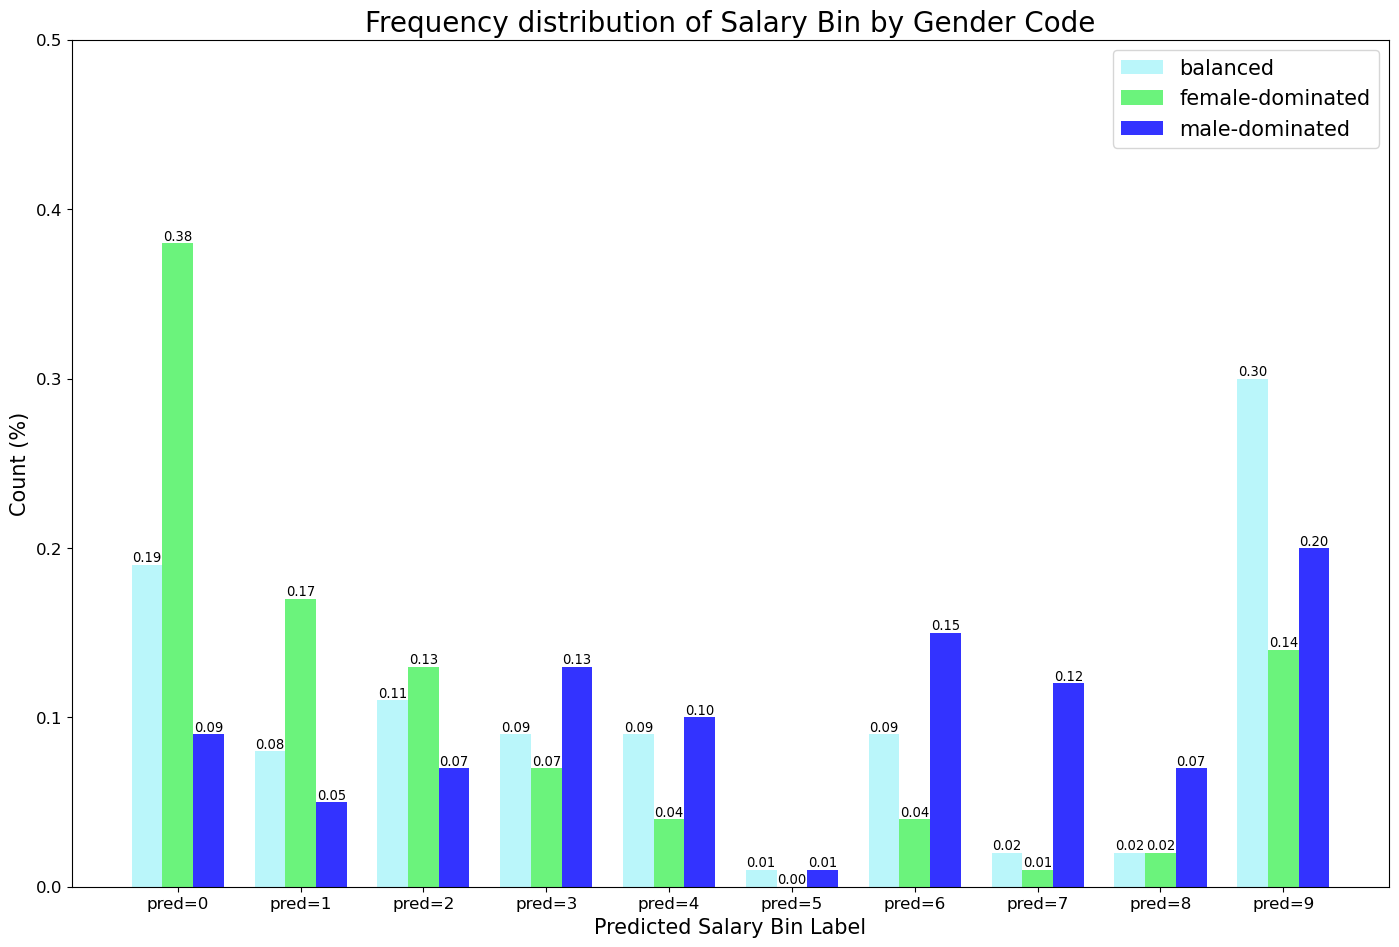

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(17,11))
x_labels = list(range(10))

bar0_height = list(mega_group_df_final[0])
bar1_height = list(mega_group_df_final[1])
bar2_height = list(mega_group_df_final[2])

bar1 = plt.bar(x = [i - 0.25 for i in range(10)], height = bar0_height, width = 0.25, alpha = 0.8, color = '#A9F4F9',label = 'balanced')  
bar2 = plt.bar(x = [i for i in range(10)], height = bar1_height, width = 0.25, alpha = 0.8, color = '#46F15B',label = 'female-dominated')  
bar3 = plt.bar(x = [i + 0.25 for i in range(10)], height = bar2_height, width = 0.25, alpha = 0.8, color = 'b',label = 'male-dominated')  

plt.bar_label(bar1, fmt='%.2f', size=9.5)
plt.bar_label(bar2, fmt='%.2f', size=9.5)
plt.bar_label(bar3, fmt='%.2f', size=9.5)

plt.ylabel('Count (%)', size= 15)
plt.xlabel('Predicted Salary Bin Label', size= 15)
plt.title('Frequency distribution of Salary Bin by Gender Code', size =20)
plt.ylim([0.0, 0.5])
plt.xticks(list(range(10)), list(mega_group_df_final.index), size= 12)
plt.yticks(fontsize=12)
plt.legend(prop={'size': 15}) 
plt.show()

# 2. Random Forest

## Parameter Fine Tunning

In [63]:
from sklearn.ensemble import RandomForestClassifier
# fine tunning

params_rf = {
             'max_depth': [10, 20, 30],
}

rf = RandomForestClassifier(n_estimators=1000,random_state=1)

rf_cv = GridSearchCV(rf, params_rf, cv=2)
rf_cv.fit(valid_embeddings, valid_salary_bin)
print("embedding", rf_cv.best_params_, rf_cv.best_score_)

rf_cv = GridSearchCV(rf,params_rf, cv=2)
rf_cv.fit(valid_tfidf, valid_salary_bin)
print("tfidf", rf_cv.best_params_, rf_cv.best_score_)

embedding {'max_depth': 20} 0.22740132468593066
tfidf {'max_depth': 20} 0.22970016916525696


## Classification for embedding feature¶

In [64]:
## classification for embedding features
rf = RandomForestClassifier(n_estimators=100, max_depth=5,random_state=1)
rf.fit(train_label_embeddings, train_cls_labels)
valid_pred = rf.predict(valid_embeddings)

print("Random Forest Method with embeddings")
print(classification_report(valid_salary_bin, valid_pred, digits=3))



Random Forest Method with embeddings
              precision    recall  f1-score   support

           0      0.325     0.767     0.457       180
           1      0.185     0.070     0.102       142
           2      0.182     0.055     0.085       181
           3      0.153     0.189     0.169       190
           4      0.137     0.070     0.092       201
           5      0.000     0.000     0.000       150
           6      0.210     0.371     0.268       178
           7      0.286     0.023     0.043       171
           8      0.308     0.023     0.043       171
           9      0.221     0.671     0.332       173

    accuracy                          0.229      1737
   macro avg      0.201     0.224     0.159      1737
weighted avg      0.202     0.229     0.163      1737



/Users/lornay/opt/anaconda3/envs/AI/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lornay/opt/anaconda3/envs/AI/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lornay/opt/anaconda3/envs/AI/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

## Fairness

In [65]:

# some random numbers
y_true = valid_salary_bin
y_pred = valid_pred
sensitive_features =valid_df['gender_code'].to_numpy()

# pandified confusion matrix with clarifying column annotations 
def confusion_matrix_pd(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred, normalize='all')
    return pd.DataFrame(matrix).rename(
               index={0: "true=0", 1: "true=1", 2: "true=2",3: "true=3", 4: "true=4", 5: "true=5",6: "true=6", 7: "true=7", 8: "true=8", 9: "true=9"},
               columns={0: "pred=0", 1: "pred=1", 2: "pred=2",3: "pred=3", 4: "pred=4", 5: "pred=5",6: "pred=6", 7: "pred=7", 8: "pred=8", 9: "pred=9"}).stack()

# construct metric frame
mf = MetricFrame(metric=confusion_matrix_pd, 
                  y_true=y_true, y_pred=y_pred, 
                  sensitive_features=sensitive_features)

# mf.by_group needs to be transformed to work properly
mega_group_df = pd.DataFrame(mf.by_group.to_dict()).T.rename_axis(index='sensitive_feature_0')
mega_group_df_final = (mega_group_df['true=0'] + mega_group_df['true=1']+ mega_group_df['true=2']+ mega_group_df['true=3']
+ mega_group_df['true=4']+ mega_group_df['true=5']+ mega_group_df['true=6']+ mega_group_df['true=7']
+ mega_group_df['true=8']+ mega_group_df['true=9'])
mega_group_df_final

/Users/lornay/opt/anaconda3/envs/AI/lib/python3.8/site-packages/fairlearn/metrics/_metric_frame.py:82: FutureWarning: The positional argument 'metric' has been replaced by a keyword argument 'metrics'. From version 0.10.0 passing it as a positional argument or as a keyword argument 'metric' will result in an error
  warnings.warn(


,pred=0,pred=1,pred=2,pred=3,pred=4,pred=5,pred=6,pred=7,pred=8,pred=9
sensitive_feature_0,,,,,,,,,,
0,0.250667,0.034667,0.045333,0.130667,0.056000,0.0,0.077333,0.002667,0.000000,0.402667
1,0.567474,0.058824,0.041522,0.103806,0.027682,0.0,0.038062,0.003460,0.000000,0.159170
2,0.154706,0.022367,0.024231,0.145387,0.068034,0.0,0.256291,0.011184,0.012116,0.305685


In [66]:
mega_group_df_final = mega_group_df_final.round(2)
mega_group_df_final = mega_group_df_final.T
mega_group_df_final

sensitive_feature_0,0,1,2
pred=0,0.25,0.57,0.15
pred=1,0.03,0.06,0.02
pred=2,0.05,0.04,0.02
pred=3,0.13,0.10,0.15
pred=4,0.06,0.03,0.07
pred=5,0.00,0.00,0.00
pred=6,0.08,0.04,0.26
pred=7,0.00,0.00,0.01
pred=8,0.00,0.00,0.01
pred=9,0.40,0.16,0.31


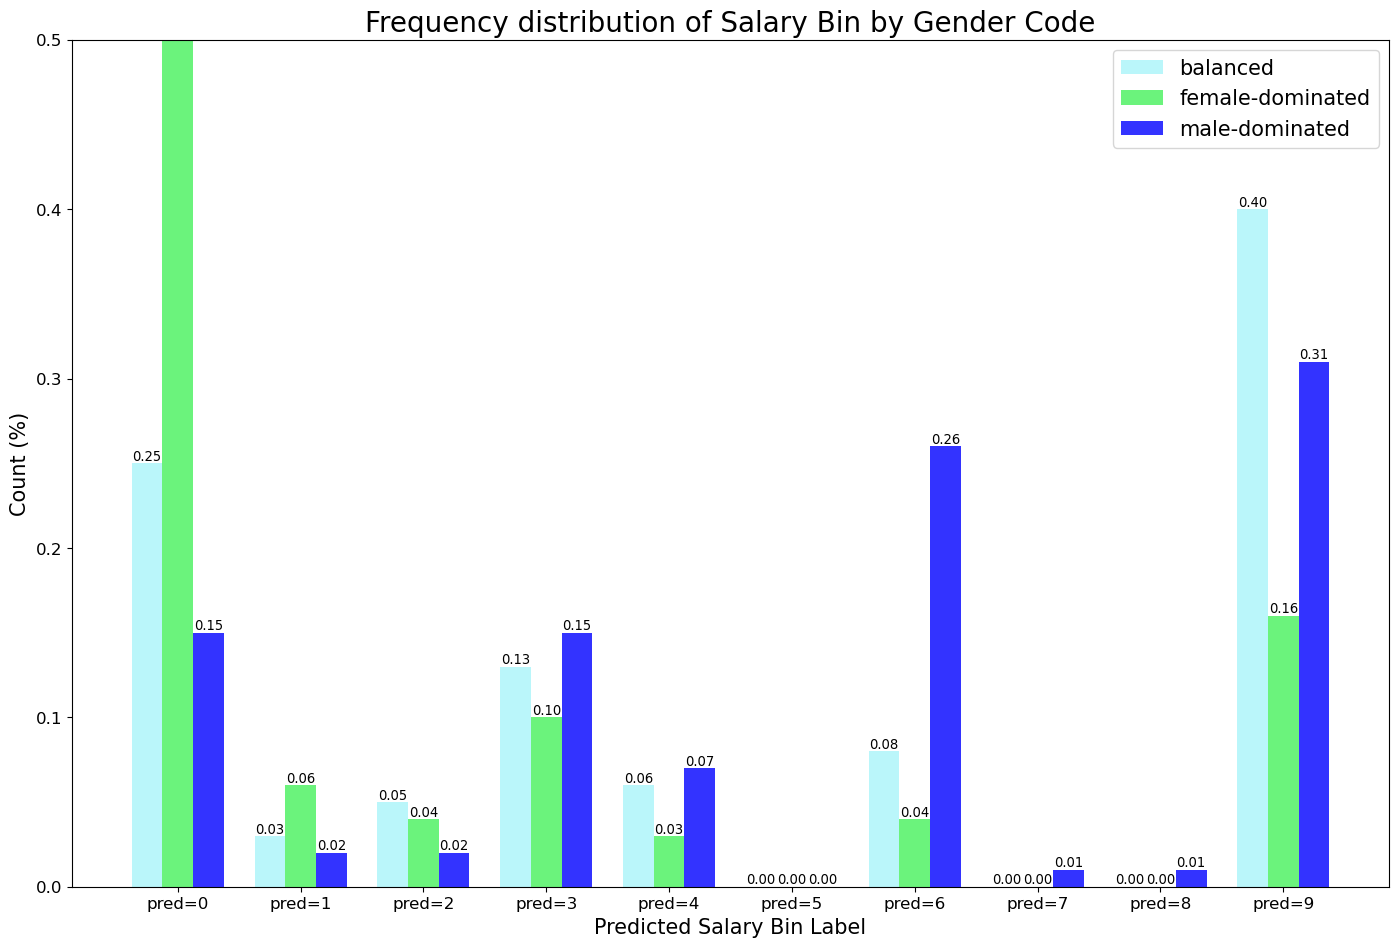

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(17,11))
x_labels = list(range(10))

bar0_height = list(mega_group_df_final[0])
bar1_height = list(mega_group_df_final[1])
bar2_height = list(mega_group_df_final[2])

bar1 = plt.bar(x = [i - 0.25 for i in range(10)], height = bar0_height, width = 0.25, alpha = 0.8, color = '#A9F4F9',label = 'balanced')  
bar2 = plt.bar(x = [i for i in range(10)], height = bar1_height, width = 0.25, alpha = 0.8, color = '#46F15B',label = 'female-dominated')  
bar3 = plt.bar(x = [i + 0.25 for i in range(10)], height = bar2_height, width = 0.25, alpha = 0.8, color = 'b',label = 'male-dominated')  

plt.bar_label(bar1, fmt='%.2f', size=9.5)
plt.bar_label(bar2, fmt='%.2f', size=9.5)
plt.bar_label(bar3, fmt='%.2f', size=9.5)

plt.ylabel('Count (%)', size= 15)
plt.xlabel('Predicted Salary Bin Label', size= 15)
plt.title('Frequency distribution of Salary Bin by Gender Code', size =20)
plt.ylim([0.0, 0.5])
plt.xticks(list(range(10)), list(mega_group_df_final.index), size= 12)
plt.yticks(fontsize=12)
plt.legend(prop={'size': 15}) 
plt.show()

## Classification for tfidf features

In [68]:
## classification for tfidf features

rf = RandomForestClassifier(n_estimators=1000, max_depth=20,  random_state=1)
rf.fit(train_label_tfidf, train_cls_labels)
valid_pred = rf.predict(valid_tfidf)

print("Random Forest Method with tfidf")
print(classification_report(valid_salary_bin, valid_pred, digits=3))

Random Forest Method with tfidf
              precision    recall  f1-score   support

           0      0.356     0.767     0.486       180
           1      0.284     0.190     0.228       142
           2      0.189     0.110     0.139       181
           3      0.181     0.200     0.190       190
           4      0.259     0.109     0.154       201
           5      0.200     0.020     0.036       150
           6      0.184     0.264     0.217       178
           7      0.274     0.170     0.209       171
           8      0.323     0.123     0.178       171
           9      0.252     0.601     0.356       173

    accuracy                          0.258      1737
   macro avg      0.250     0.255     0.219      1737
weighted avg      0.250     0.258     0.221      1737



## Fairness

In [69]:

# some random numbers
y_true = valid_salary_bin
y_pred = valid_pred
sensitive_features =valid_df['gender_code'].to_numpy()

# pandified confusion matrix with clarifying column annotations 
def confusion_matrix_pd(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred, normalize='all')
    return pd.DataFrame(matrix).rename(
               index={0: "true=0", 1: "true=1", 2: "true=2",3: "true=3", 4: "true=4", 5: "true=5",6: "true=6", 7: "true=7", 8: "true=8", 9: "true=9"},
               columns={0: "pred=0", 1: "pred=1", 2: "pred=2",3: "pred=3", 4: "pred=4", 5: "pred=5",6: "pred=6", 7: "pred=7", 8: "pred=8", 9: "pred=9"}).stack()

# construct metric frame
mf = MetricFrame(metric=confusion_matrix_pd, 
                  y_true=y_true, y_pred=y_pred, 
                  sensitive_features=sensitive_features)

# mf.by_group needs to be transformed to work properly
mega_group_df = pd.DataFrame(mf.by_group.to_dict()).T.rename_axis(index='sensitive_feature_0')
mega_group_df_final = (mega_group_df['true=0'] + mega_group_df['true=1']+ mega_group_df['true=2']+ mega_group_df['true=3']
+ mega_group_df['true=4']+ mega_group_df['true=5']+ mega_group_df['true=6']+ mega_group_df['true=7']
+ mega_group_df['true=8']+ mega_group_df['true=9'])
mega_group_df_final

/Users/lornay/opt/anaconda3/envs/AI/lib/python3.8/site-packages/fairlearn/metrics/_metric_frame.py:82: FutureWarning: The positional argument 'metric' has been replaced by a keyword argument 'metrics'. From version 0.10.0 passing it as a positional argument or as a keyword argument 'metric' will result in an error
  warnings.warn(


,pred=0,pred=1,pred=2,pred=3,pred=4,pred=5,pred=6,pred=7,pred=8,pred=9
sensitive_feature_0,,,,,,,,,,
0,0.234667,0.080000,0.080000,0.093333,0.029333,0.005333,0.112000,0.018667,0.026667,0.320000
1,0.474048,0.107266,0.072664,0.086505,0.010381,0.003460,0.065744,0.013841,0.017301,0.148789
2,0.151911,0.031687,0.051258,0.139795,0.066170,0.011184,0.180801,0.088537,0.046598,0.232060


In [70]:
mega_group_df_final = mega_group_df_final.round(2)
mega_group_df_final = mega_group_df_final.T
mega_group_df_final

sensitive_feature_0,0,1,2
pred=0,0.23,0.47,0.15
pred=1,0.08,0.11,0.03
pred=2,0.08,0.07,0.05
pred=3,0.09,0.09,0.14
pred=4,0.03,0.01,0.07
pred=5,0.01,0.00,0.01
pred=6,0.11,0.07,0.18
pred=7,0.02,0.01,0.09
pred=8,0.03,0.02,0.05
pred=9,0.32,0.15,0.23


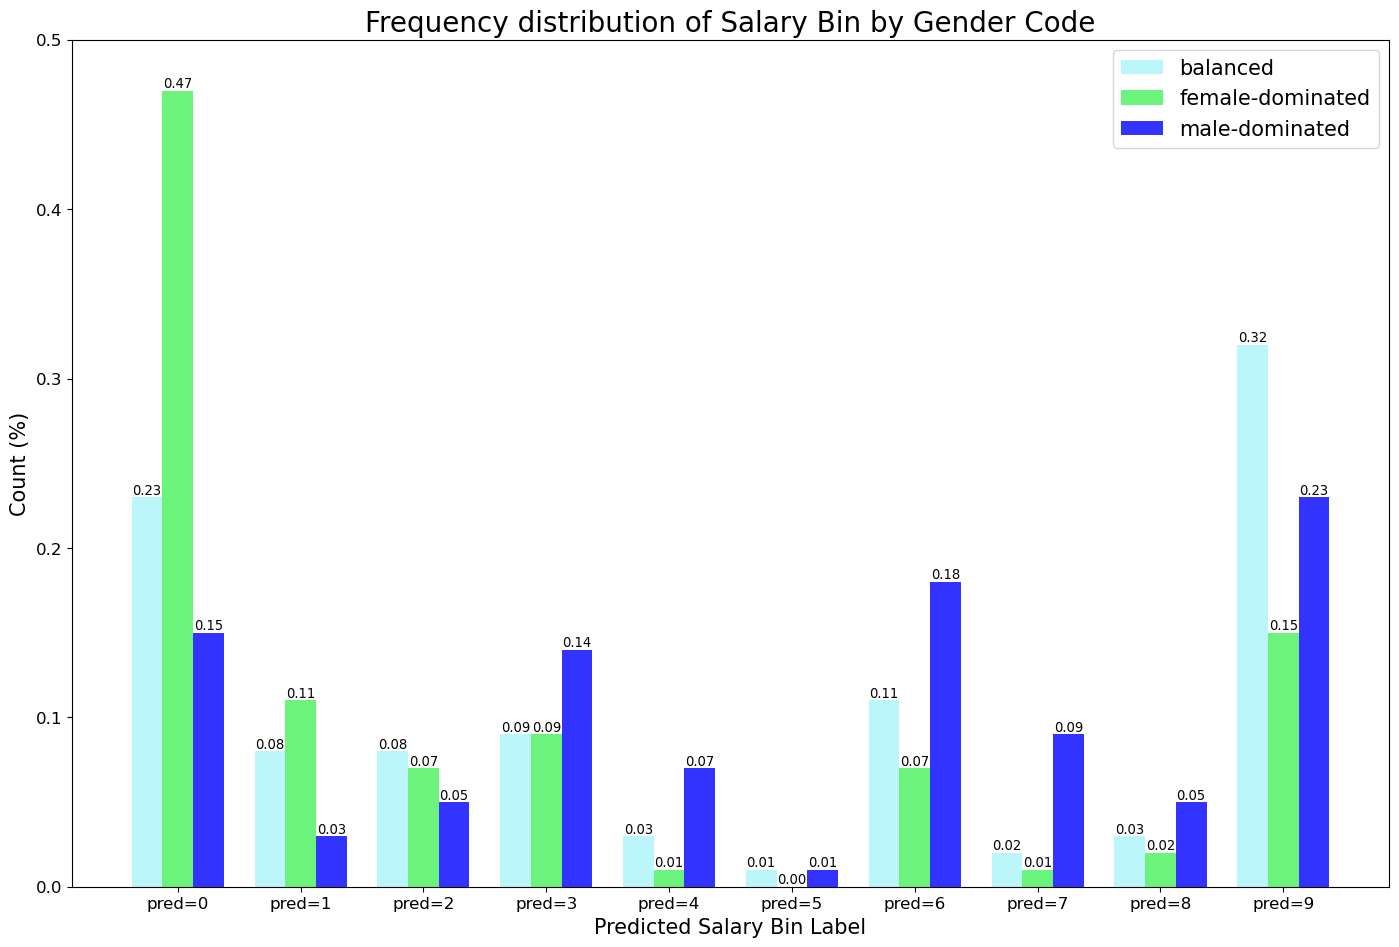

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(17,11))
x_labels = list(range(10))

bar0_height = list(mega_group_df_final[0])
bar1_height = list(mega_group_df_final[1])
bar2_height = list(mega_group_df_final[2])

bar1 = plt.bar(x = [i - 0.25 for i in range(10)], height = bar0_height, width = 0.25, alpha = 0.8, color = '#A9F4F9',label = 'balanced')  
bar2 = plt.bar(x = [i for i in range(10)], height = bar1_height, width = 0.25, alpha = 0.8, color = '#46F15B',label = 'female-dominated')  
bar3 = plt.bar(x = [i + 0.25 for i in range(10)], height = bar2_height, width = 0.25, alpha = 0.8, color = 'b',label = 'male-dominated')  

plt.bar_label(bar1, fmt='%.2f', size=9.5)
plt.bar_label(bar2, fmt='%.2f', size=9.5)
plt.bar_label(bar3, fmt='%.2f', size=9.5)

plt.ylabel('Count (%)', size= 15)
plt.xlabel('Predicted Salary Bin Label', size= 15)
plt.title('Frequency distribution of Salary Bin by Gender Code', size =20)
plt.ylim([0.0, 0.5])
plt.xticks(list(range(10)), list(mega_group_df_final.index), size= 12)
plt.yticks(fontsize=12)
plt.legend(prop={'size': 15}) 
plt.show()

# 3. KNN

## Parameter Fine Tunning

In [72]:
from sklearn.neighbors import KNeighborsClassifier
# fine tunning

params_knn = {
             'n_neighbors': [5, 10, 20, 30],
}

knn = KNeighborsClassifier(metric='cosine')

knn_cv = GridSearchCV(knn, params_knn, cv=2)
knn_cv.fit(valid_embeddings, valid_salary_bin)
print("embedding", knn_cv.best_params_, knn_cv.best_score_)

knn_cv = GridSearchCV(knn, params_knn, cv=2)
knn_cv.fit(valid_tfidf, valid_salary_bin)
print("tfidf", knn_cv.best_params_, knn_cv.best_score_)

embedding {'n_neighbors': 30} 0.19746729383315745
tfidf {'n_neighbors': 30} 0.18135682202648312


## Classification for embedding feature

In [73]:

## classification for embedding features
knn = KNeighborsClassifier(n_neighbors=30, metric='cosine')
knn.fit(train_label_embeddings, train_cls_labels)
valid_pred = knn.predict(valid_embeddings)

print("K-Nearest Neighbors with embeddings ")
print(classification_report(valid_salary_bin, valid_pred, digits=3))



K-Nearest Neighbors with embeddings 
              precision    recall  f1-score   support

           0      0.435     0.467     0.450       180
           1      0.200     0.289     0.236       142
           2      0.172     0.215     0.191       181
           3      0.109     0.089     0.098       190
           4      0.224     0.149     0.179       201
           5      0.218     0.080     0.117       150
           6      0.158     0.169     0.163       178
           7      0.200     0.164     0.180       171
           8      0.215     0.216     0.216       171
           9      0.298     0.457     0.361       173

    accuracy                          0.229      1737
   macro avg      0.223     0.229     0.219      1737
weighted avg      0.223     0.229     0.219      1737



## Fairness

In [74]:

# some random numbers
y_true = valid_salary_bin
y_pred = valid_pred
sensitive_features =valid_df['gender_code'].to_numpy()

# pandified confusion matrix with clarifying column annotations 
def confusion_matrix_pd(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred, normalize='all')
    return pd.DataFrame(matrix).rename(
               index={0: "true=0", 1: "true=1", 2: "true=2",3: "true=3", 4: "true=4", 5: "true=5",6: "true=6", 7: "true=7", 8: "true=8", 9: "true=9"},
               columns={0: "pred=0", 1: "pred=1", 2: "pred=2",3: "pred=3", 4: "pred=4", 5: "pred=5",6: "pred=6", 7: "pred=7", 8: "pred=8", 9: "pred=9"}).stack()

# construct metric frame
mf = MetricFrame(metric=confusion_matrix_pd, 
                  y_true=y_true, y_pred=y_pred, 
                  sensitive_features=sensitive_features)

# mf.by_group needs to be transformed to work properly
mega_group_df = pd.DataFrame(mf.by_group.to_dict()).T.rename_axis(index='sensitive_feature_0')
mega_group_df_final = (mega_group_df['true=0'] + mega_group_df['true=1']+ mega_group_df['true=2']+ mega_group_df['true=3']
+ mega_group_df['true=4']+ mega_group_df['true=5']+ mega_group_df['true=6']+ mega_group_df['true=7']
+ mega_group_df['true=8']+ mega_group_df['true=9'])
mega_group_df_final

/Users/lornay/opt/anaconda3/envs/AI/lib/python3.8/site-packages/fairlearn/metrics/_metric_frame.py:82: FutureWarning: The positional argument 'metric' has been replaced by a keyword argument 'metrics'. From version 0.10.0 passing it as a positional argument or as a keyword argument 'metric' will result in an error
  warnings.warn(


,pred=0,pred=1,pred=2,pred=3,pred=4,pred=5,pred=6,pred=7,pred=8,pred=9
sensitive_feature_0,,,,,,,,,,
0,0.125333,0.133333,0.157333,0.069333,0.074667,0.021333,0.077333,0.048000,0.064000,0.229333
1,0.297578,0.314879,0.093426,0.083045,0.031142,0.017301,0.038062,0.013841,0.034602,0.076125
2,0.055918,0.059646,0.131407,0.098788,0.090401,0.039143,0.139795,0.109972,0.128611,0.146319


In [75]:
mega_group_df_final = mega_group_df_final.round(2)
mega_group_df_final = mega_group_df_final.T
mega_group_df_final

sensitive_feature_0,0,1,2
pred=0,0.13,0.30,0.06
pred=1,0.13,0.31,0.06
pred=2,0.16,0.09,0.13
pred=3,0.07,0.08,0.10
pred=4,0.07,0.03,0.09
pred=5,0.02,0.02,0.04
pred=6,0.08,0.04,0.14
pred=7,0.05,0.01,0.11
pred=8,0.06,0.03,0.13
pred=9,0.23,0.08,0.15


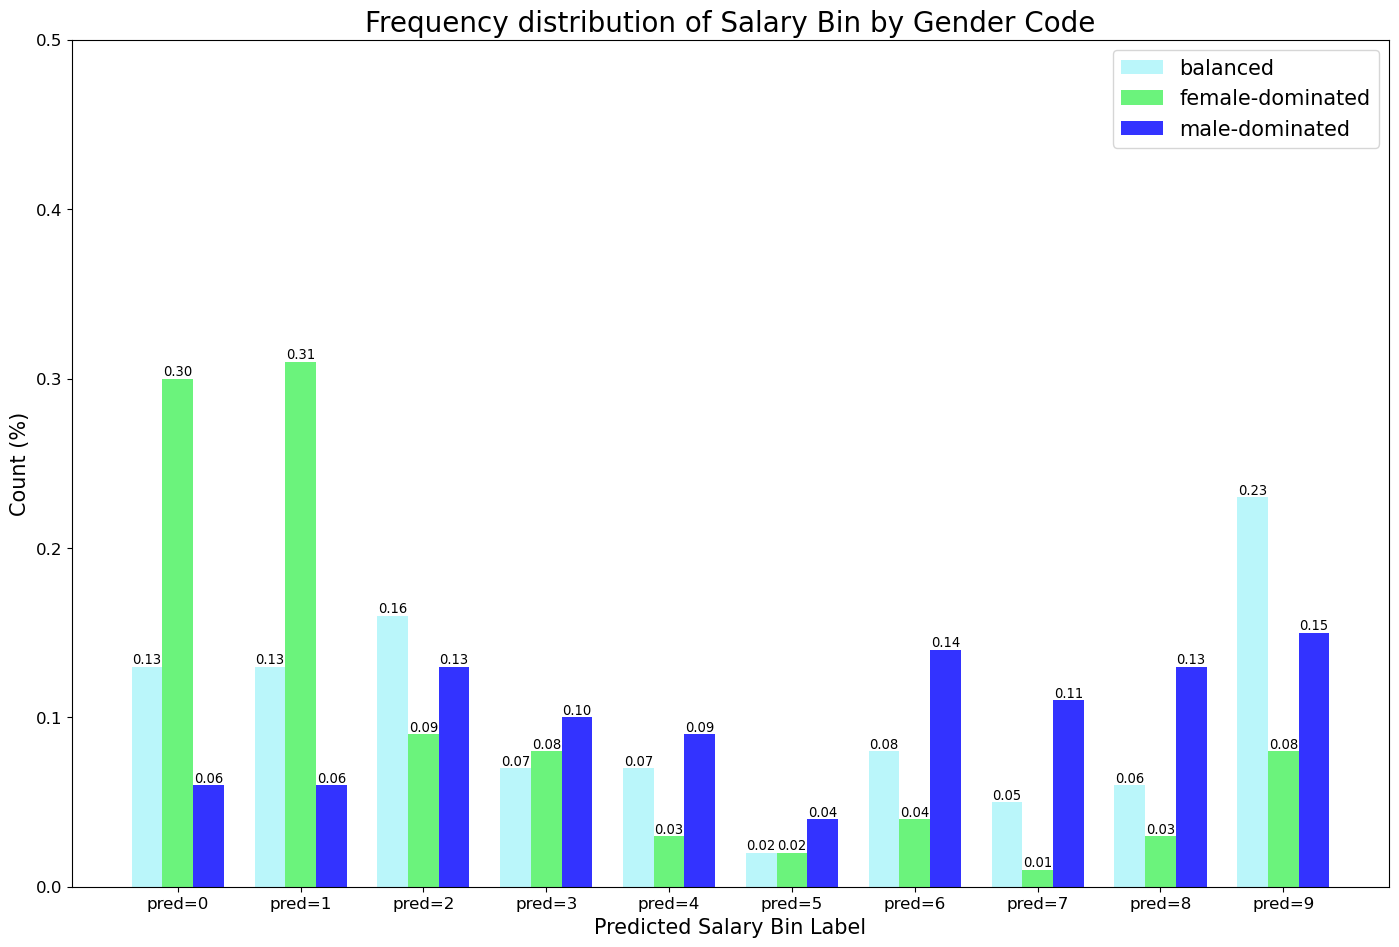

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(17,11))
x_labels = list(range(10))

bar0_height = list(mega_group_df_final[0])
bar1_height = list(mega_group_df_final[1])
bar2_height = list(mega_group_df_final[2])

bar1 = plt.bar(x = [i - 0.25 for i in range(10)], height = bar0_height, width = 0.25, alpha = 0.8, color = '#A9F4F9',label = 'balanced')  
bar2 = plt.bar(x = [i for i in range(10)], height = bar1_height, width = 0.25, alpha = 0.8, color = '#46F15B',label = 'female-dominated')  
bar3 = plt.bar(x = [i + 0.25 for i in range(10)], height = bar2_height, width = 0.25, alpha = 0.8, color = 'b',label = 'male-dominated')  

plt.bar_label(bar1, fmt='%.2f', size=9.5)
plt.bar_label(bar2, fmt='%.2f', size=9.5)
plt.bar_label(bar3, fmt='%.2f', size=9.5)

plt.ylabel('Count (%)', size= 15)
plt.xlabel('Predicted Salary Bin Label', size= 15)
plt.title('Frequency distribution of Salary Bin by Gender Code', size =20)
plt.ylim([0.0, 0.5])
plt.xticks(list(range(10)), list(mega_group_df_final.index), size= 12)
plt.yticks(fontsize=12)
plt.legend(prop={'size': 15}) 
plt.show()

## classification for tfidf features

In [77]:


knn = KNeighborsClassifier(n_neighbors=30, metric='cosine')
knn.fit(train_label_tfidf, train_cls_labels)
valid_pred = knn.predict(valid_tfidf)

print("K-Nearest Neighbors Method with tfidf ")
print(classification_report(valid_salary_bin, valid_pred, digits=3))

K-Nearest Neighbors Method with tfidf 
              precision    recall  f1-score   support

           0      0.322     0.544     0.405       180
           1      0.173     0.169     0.171       142
           2      0.156     0.144     0.149       181
           3      0.230     0.237     0.233       190
           4      0.193     0.134     0.158       201
           5      0.132     0.047     0.069       150
           6      0.147     0.140     0.144       178
           7      0.168     0.158     0.163       171
           8      0.170     0.135     0.150       171
           9      0.257     0.405     0.315       173

    accuracy                          0.214      1737
   macro avg      0.195     0.211     0.196      1737
weighted avg      0.197     0.214     0.198      1737



## Fairness

In [78]:

# some random numbers
y_true = valid_salary_bin
y_pred = valid_pred
sensitive_features =valid_df['gender_code'].to_numpy()

# pandified confusion matrix with clarifying column annotations 
def confusion_matrix_pd(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred, normalize='all')
    return pd.DataFrame(matrix).rename(
               index={0: "true=0", 1: "true=1", 2: "true=2",3: "true=3", 4: "true=4", 5: "true=5",6: "true=6", 7: "true=7", 8: "true=8", 9: "true=9"},
               columns={0: "pred=0", 1: "pred=1", 2: "pred=2",3: "pred=3", 4: "pred=4", 5: "pred=5",6: "pred=6", 7: "pred=7", 8: "pred=8", 9: "pred=9"}).stack()

# construct metric frame
mf = MetricFrame(metric=confusion_matrix_pd, 
                  y_true=y_true, y_pred=y_pred, 
                  sensitive_features=sensitive_features)

# mf.by_group needs to be transformed to work properly
mega_group_df = pd.DataFrame(mf.by_group.to_dict()).T.rename_axis(index='sensitive_feature_0')
mega_group_df_final = (mega_group_df['true=0'] + mega_group_df['true=1']+ mega_group_df['true=2']+ mega_group_df['true=3']
+ mega_group_df['true=4']+ mega_group_df['true=5']+ mega_group_df['true=6']+ mega_group_df['true=7']
+ mega_group_df['true=8']+ mega_group_df['true=9'])
mega_group_df_final

/Users/lornay/opt/anaconda3/envs/AI/lib/python3.8/site-packages/fairlearn/metrics/_metric_frame.py:82: FutureWarning: The positional argument 'metric' has been replaced by a keyword argument 'metrics'. From version 0.10.0 passing it as a positional argument or as a keyword argument 'metric' will result in an error
  warnings.warn(


,pred=0,pred=1,pred=2,pred=3,pred=4,pred=5,pred=6,pred=7,pred=8,pred=9
sensitive_feature_0,,,,,,,,,,
0,0.200000,0.117333,0.096000,0.077333,0.066667,0.034667,0.069333,0.053333,0.072000,0.213333
1,0.446367,0.124567,0.114187,0.086505,0.034602,0.017301,0.031142,0.041522,0.024221,0.079585
2,0.093197,0.054986,0.091333,0.132339,0.097856,0.032619,0.125815,0.120224,0.094129,0.157502


In [79]:
mega_group_df_final = mega_group_df_final.round(2)
mega_group_df_final = mega_group_df_final.T
mega_group_df_final

sensitive_feature_0,0,1,2
pred=0,0.20,0.45,0.09
pred=1,0.12,0.12,0.05
pred=2,0.10,0.11,0.09
pred=3,0.08,0.09,0.13
pred=4,0.07,0.03,0.10
pred=5,0.03,0.02,0.03
pred=6,0.07,0.03,0.13
pred=7,0.05,0.04,0.12
pred=8,0.07,0.02,0.09
pred=9,0.21,0.08,0.16


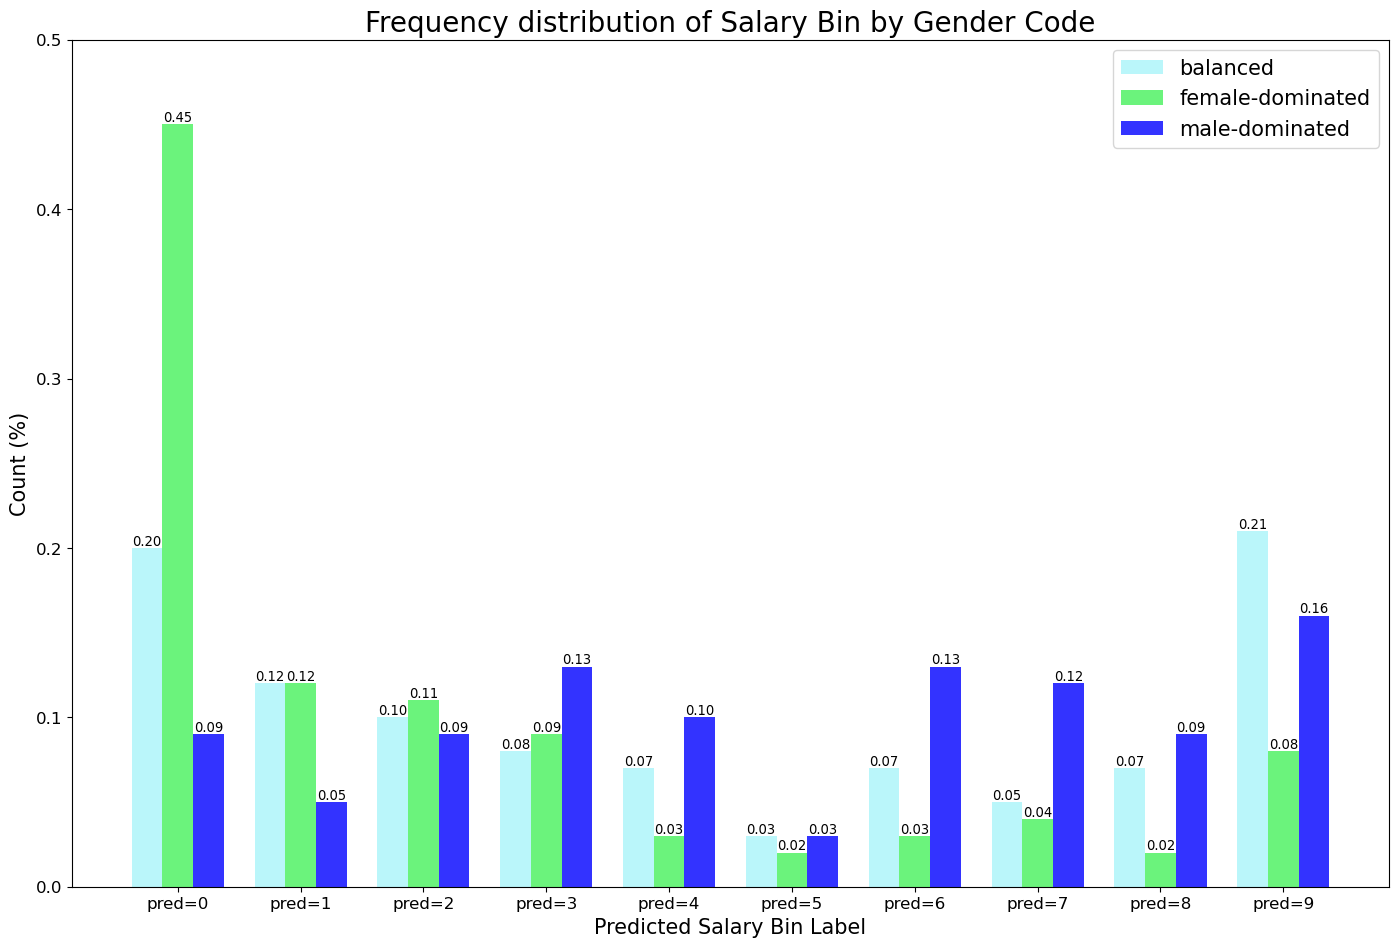

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(17,11))
x_labels = list(range(10))

bar0_height = list(mega_group_df_final[0])
bar1_height = list(mega_group_df_final[1])
bar2_height = list(mega_group_df_final[2])

bar1 = plt.bar(x = [i - 0.25 for i in range(10)], height = bar0_height, width = 0.25, alpha = 0.8, color = '#A9F4F9',label = 'balanced')  
bar2 = plt.bar(x = [i for i in range(10)], height = bar1_height, width = 0.25, alpha = 0.8, color = '#46F15B',label = 'female-dominated')  
bar3 = plt.bar(x = [i + 0.25 for i in range(10)], height = bar2_height, width = 0.25, alpha = 0.8, color = 'b',label = 'male-dominated')  

plt.bar_label(bar1, fmt='%.2f', size=9.5)
plt.bar_label(bar2, fmt='%.2f', size=9.5)
plt.bar_label(bar3, fmt='%.2f', size=9.5)

plt.ylabel('Count (%)', size= 15)
plt.xlabel('Predicted Salary Bin Label', size= 15)
plt.title('Frequency distribution of Salary Bin by Gender Code', size =20)
plt.ylim([0.0, 0.5])
plt.xticks(list(range(10)), list(mega_group_df_final.index), size= 12)
plt.yticks(fontsize=12)
plt.legend(prop={'size': 15}) 
plt.show()

# 4. Baseline-Zero-R

## Classification for embedding feature

In [81]:
from sklearn.dummy import DummyClassifier
zero_r = DummyClassifier(strategy="most_frequent")
zero_r.fit(train_label_embeddings, train_cls_labels)
valid_pred = zero_r.predict(valid_embeddings)

print("Rule baseline: Zero-R with embeddings ")
print(classification_report(valid_salary_bin, valid_pred, digits=3))

Rule baseline: Zero-R with embeddings 
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       180
           1      0.000     0.000     0.000       142
           2      0.000     0.000     0.000       181
           3      0.000     0.000     0.000       190
           4      0.000     0.000     0.000       201
           5      0.000     0.000     0.000       150
           6      0.000     0.000     0.000       178
           7      0.000     0.000     0.000       171
           8      0.000     0.000     0.000       171
           9      0.100     1.000     0.181       173

    accuracy                          0.100      1737
   macro avg      0.010     0.100     0.018      1737
weighted avg      0.010     0.100     0.018      1737



/Users/lornay/opt/anaconda3/envs/AI/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lornay/opt/anaconda3/envs/AI/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lornay/opt/anaconda3/envs/AI/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

## Fairness

In [82]:

# some random numbers
y_true = valid_salary_bin
y_pred = valid_pred
sensitive_features =valid_df['gender_code'].to_numpy()

# pandified confusion matrix with clarifying column annotations 
def confusion_matrix_pd(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred, normalize='all')
    return pd.DataFrame(matrix).rename(
               index={0: "true=0", 1: "true=1", 2: "true=2",3: "true=3", 4: "true=4", 5: "true=5",6: "true=6", 7: "true=7", 8: "true=8", 9: "true=9"},
               columns={0: "pred=0", 1: "pred=1", 2: "pred=2",3: "pred=3", 4: "pred=4", 5: "pred=5",6: "pred=6", 7: "pred=7", 8: "pred=8", 9: "pred=9"}).stack()

# construct metric frame
mf = MetricFrame(metric=confusion_matrix_pd, 
                  y_true=y_true, y_pred=y_pred, 
                  sensitive_features=sensitive_features)

# mf.by_group needs to be transformed to work properly
mega_group_df = pd.DataFrame(mf.by_group.to_dict()).T.rename_axis(index='sensitive_feature_0')
mega_group_df_final = (mega_group_df['true=0'] + mega_group_df['true=1']+ mega_group_df['true=2']+ mega_group_df['true=3']
+ mega_group_df['true=4']+ mega_group_df['true=5']+ mega_group_df['true=6']+ mega_group_df['true=7']
+ mega_group_df['true=8']+ mega_group_df['true=9'])
mega_group_df_final

/Users/lornay/opt/anaconda3/envs/AI/lib/python3.8/site-packages/fairlearn/metrics/_metric_frame.py:82: FutureWarning: The positional argument 'metric' has been replaced by a keyword argument 'metrics'. From version 0.10.0 passing it as a positional argument or as a keyword argument 'metric' will result in an error
  warnings.warn(


,pred=0,pred=1,pred=2,pred=3,pred=4,pred=5,pred=6,pred=7,pred=8,pred=9
sensitive_feature_0,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [83]:
mega_group_df_final = mega_group_df_final.round(2)
mega_group_df_final = mega_group_df_final.T
mega_group_df_final

sensitive_feature_0,0,1,2
pred=0,0.0,0.0,0.0
pred=1,0.0,0.0,0.0
pred=2,0.0,0.0,0.0
pred=3,0.0,0.0,0.0
pred=4,0.0,0.0,0.0
pred=5,0.0,0.0,0.0
pred=6,0.0,0.0,0.0
pred=7,0.0,0.0,0.0
pred=8,0.0,0.0,0.0
pred=9,1.0,1.0,1.0


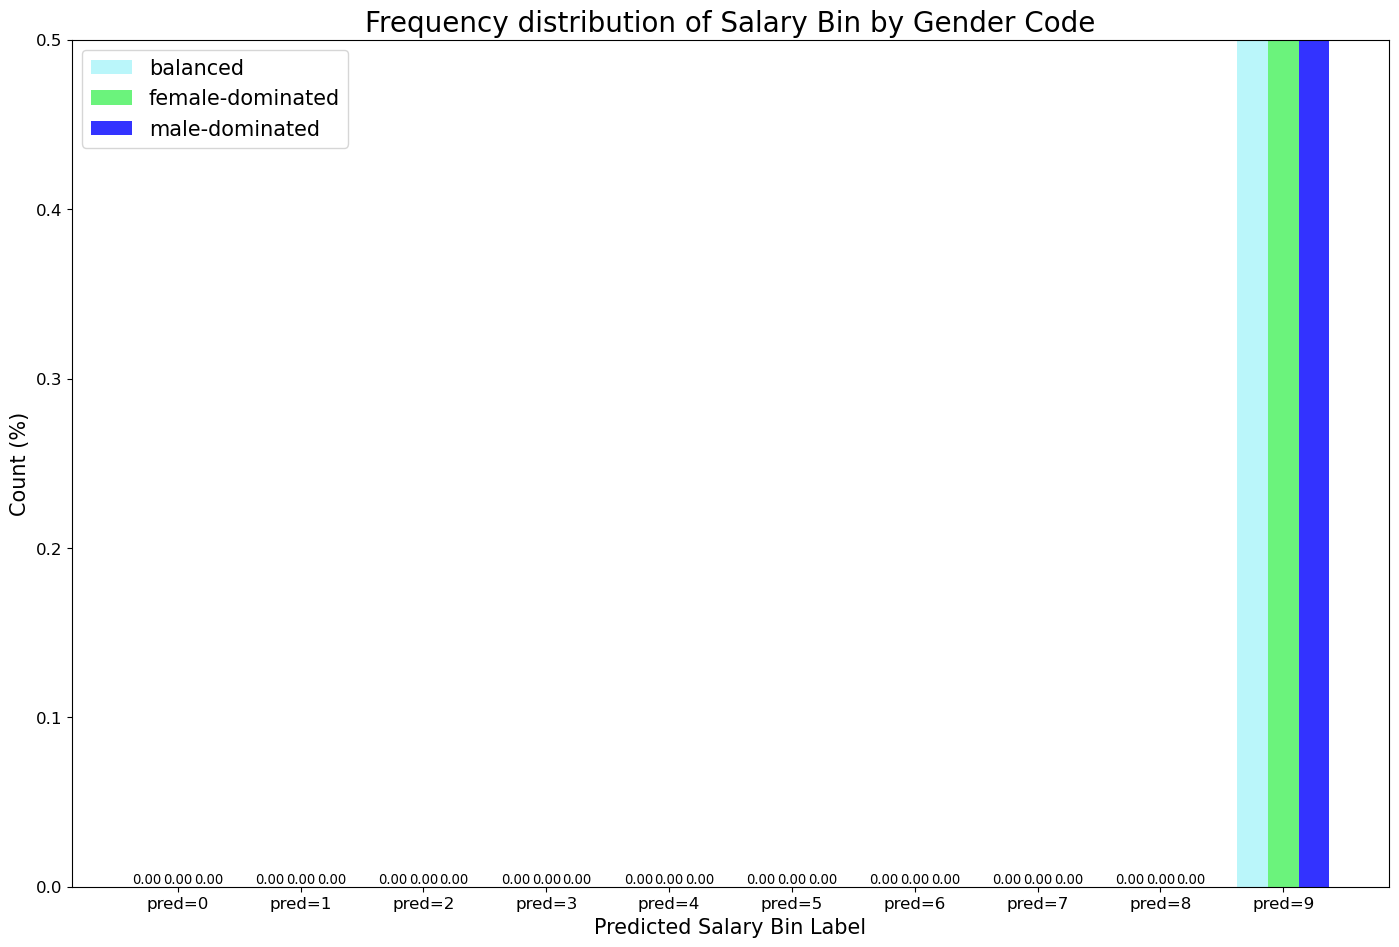

In [84]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(17,11))
x_labels = list(range(10))

bar0_height = list(mega_group_df_final[0])
bar1_height = list(mega_group_df_final[1])
bar2_height = list(mega_group_df_final[2])

bar1 = plt.bar(x = [i - 0.25 for i in range(10)], height = bar0_height, width = 0.25, alpha = 0.8, color = '#A9F4F9',label = 'balanced')  
bar2 = plt.bar(x = [i for i in range(10)], height = bar1_height, width = 0.25, alpha = 0.8, color = '#46F15B',label = 'female-dominated')  
bar3 = plt.bar(x = [i + 0.25 for i in range(10)], height = bar2_height, width = 0.25, alpha = 0.8, color = 'b',label = 'male-dominated')  

plt.bar_label(bar1, fmt='%.2f', size=9.5)
plt.bar_label(bar2, fmt='%.2f', size=9.5)
plt.bar_label(bar3, fmt='%.2f', size=9.5)

plt.ylabel('Count (%)', size= 15)
plt.xlabel('Predicted Salary Bin Label', size= 15)
plt.title('Frequency distribution of Salary Bin by Gender Code', size =20)
plt.ylim([0.0, 0.5])
plt.xticks(list(range(10)), list(mega_group_df_final.index), size= 12)
plt.yticks(fontsize=12)
plt.legend(prop={'size': 15}) 
plt.show()

## Classification for TFIDF feature

In [85]:

zero_r = DummyClassifier(strategy="most_frequent")
zero_r.fit(train_label_tfidf, train_cls_labels)
valid_pred = zero_r.predict(valid_tfidf)

print("Rule baseline: Zero-R with tfidf ")
print(classification_report(valid_salary_bin, valid_pred, digits=3))

Rule baseline: Zero-R with tfidf 
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       180
           1      0.000     0.000     0.000       142
           2      0.000     0.000     0.000       181
           3      0.000     0.000     0.000       190
           4      0.000     0.000     0.000       201
           5      0.000     0.000     0.000       150
           6      0.000     0.000     0.000       178
           7      0.000     0.000     0.000       171
           8      0.000     0.000     0.000       171
           9      0.100     1.000     0.181       173

    accuracy                          0.100      1737
   macro avg      0.010     0.100     0.018      1737
weighted avg      0.010     0.100     0.018      1737



/Users/lornay/opt/anaconda3/envs/AI/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lornay/opt/anaconda3/envs/AI/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lornay/opt/anaconda3/envs/AI/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

## Fairness

In [86]:

# some random numbers
y_true = valid_salary_bin
y_pred = valid_pred
sensitive_features =valid_df['gender_code'].to_numpy()

# pandified confusion matrix with clarifying column annotations 
def confusion_matrix_pd(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred, normalize='all')
    return pd.DataFrame(matrix).rename(
               index={0: "true=0", 1: "true=1", 2: "true=2",3: "true=3", 4: "true=4", 5: "true=5",6: "true=6", 7: "true=7", 8: "true=8", 9: "true=9"},
               columns={0: "pred=0", 1: "pred=1", 2: "pred=2",3: "pred=3", 4: "pred=4", 5: "pred=5",6: "pred=6", 7: "pred=7", 8: "pred=8", 9: "pred=9"}).stack()

# construct metric frame
mf = MetricFrame(metric=confusion_matrix_pd, 
                  y_true=y_true, y_pred=y_pred, 
                  sensitive_features=sensitive_features)

# mf.by_group needs to be transformed to work properly
mega_group_df = pd.DataFrame(mf.by_group.to_dict()).T.rename_axis(index='sensitive_feature_0')
mega_group_df_final = (mega_group_df['true=0'] + mega_group_df['true=1']+ mega_group_df['true=2']+ mega_group_df['true=3']
+ mega_group_df['true=4']+ mega_group_df['true=5']+ mega_group_df['true=6']+ mega_group_df['true=7']
+ mega_group_df['true=8']+ mega_group_df['true=9'])
mega_group_df_final

/Users/lornay/opt/anaconda3/envs/AI/lib/python3.8/site-packages/fairlearn/metrics/_metric_frame.py:82: FutureWarning: The positional argument 'metric' has been replaced by a keyword argument 'metrics'. From version 0.10.0 passing it as a positional argument or as a keyword argument 'metric' will result in an error
  warnings.warn(


,pred=0,pred=1,pred=2,pred=3,pred=4,pred=5,pred=6,pred=7,pred=8,pred=9
sensitive_feature_0,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [87]:
mega_group_df_final = mega_group_df_final.round(2)
mega_group_df_final = mega_group_df_final.T
mega_group_df_final

sensitive_feature_0,0,1,2
pred=0,0.0,0.0,0.0
pred=1,0.0,0.0,0.0
pred=2,0.0,0.0,0.0
pred=3,0.0,0.0,0.0
pred=4,0.0,0.0,0.0
pred=5,0.0,0.0,0.0
pred=6,0.0,0.0,0.0
pred=7,0.0,0.0,0.0
pred=8,0.0,0.0,0.0
pred=9,1.0,1.0,1.0


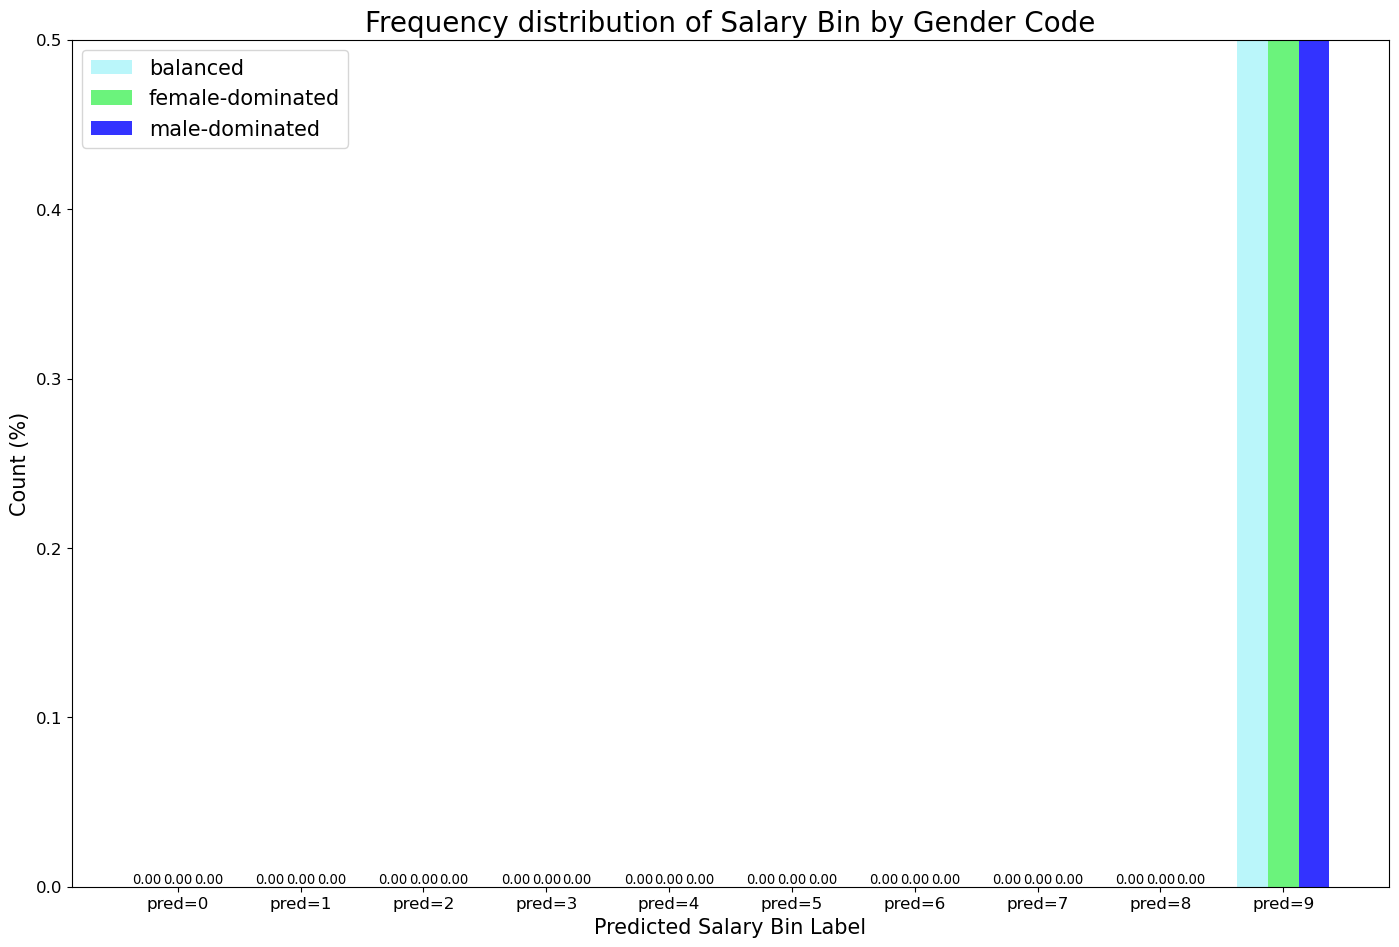

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(17,11))
x_labels = list(range(10))

bar0_height = list(mega_group_df_final[0])
bar1_height = list(mega_group_df_final[1])
bar2_height = list(mega_group_df_final[2])

bar1 = plt.bar(x = [i - 0.25 for i in range(10)], height = bar0_height, width = 0.25, alpha = 0.8, color = '#A9F4F9',label = 'balanced')  
bar2 = plt.bar(x = [i for i in range(10)], height = bar1_height, width = 0.25, alpha = 0.8, color = '#46F15B',label = 'female-dominated')  
bar3 = plt.bar(x = [i + 0.25 for i in range(10)], height = bar2_height, width = 0.25, alpha = 0.8, color = 'b',label = 'male-dominated')  

plt.bar_label(bar1, fmt='%.2f', size=9.5)
plt.bar_label(bar2, fmt='%.2f', size=9.5)
plt.bar_label(bar3, fmt='%.2f', size=9.5)

plt.ylabel('Count (%)', size= 15)
plt.xlabel('Predicted Salary Bin Label', size= 15)
plt.title('Frequency distribution of Salary Bin by Gender Code', size =20)
plt.ylim([0.0, 0.5])
plt.xticks(list(range(10)), list(mega_group_df_final.index), size= 12)
plt.yticks(fontsize=12)
plt.legend(prop={'size': 15}) 
plt.show()

# Kaggle Submission

In [89]:
rf = RandomForestClassifier(n_estimators=500, max_depth=20,random_state=1)
rf.fit(train_label_embeddings, train_cls_labels)
valid_pred = rf.predict(valid_embeddings)

print("Random Forest Method")
print(classification_report(valid_salary_bin, valid_pred, digits=3))

Random Forest Method
              precision    recall  f1-score   support

           0      0.384     0.617     0.473       180
           1      0.216     0.225     0.221       142
           2      0.234     0.204     0.218       181
           3      0.202     0.195     0.198       190
           4      0.222     0.194     0.207       201
           5      0.364     0.053     0.093       150
           6      0.200     0.225     0.212       178
           7      0.292     0.181     0.224       171
           8      0.347     0.205     0.257       171
           9      0.260     0.532     0.349       173

    accuracy                          0.266      1737
   macro avg      0.272     0.263     0.245      1737
weighted avg      0.270     0.266     0.247      1737



In [90]:
# get test job id
test_ids = test_df["job_id"].to_numpy()

test_preds = rf.predict(test_embeddings).tolist()
# test_preds = LRclf.predict(test_bow).tolist()
assert len(test_ids) == len(test_preds)

f = open("test_predictions.csv", "w")
f.write("job_id,salary_bin\n")
for test_id, test_pred in zip(test_ids, test_preds):
    f.write(str(test_id) + "," +str(test_pred) + "\n")

f.close()